In [1468]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import statsmodels.formula.api as smf

# Data loading

## Movie data

movie.metadata.tsv.gz [3.4 M]
Metadata for 81,741 movies, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)

In [1469]:
# Load films
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
#movies['runtime'].hist()


(81741, 9)


In [1470]:
movies.head(5)

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [1471]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


## Character data

character.metadata.tsv.gz [14 M]
Metadata for 450,669 characters aligned to the movies above, extracted from November 4, 2012 dump of Freebase. Tab-separated; columns:

- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

In [1472]:
# Load characters
characters_header = ['wikipedia_movie_id','freebase_movie_id','movie_release_date','character_name','actor_birthdate','actor_gender','actor_height_meters','actor_ethnicity_freebase_id','actor_name','actor_age_at_movie_release','freebase_character_actor_map_id','freebase_character_id','freebase_actor_id']
characters = pd.read_csv('data/character.metadata.tsv', sep='\t', header=None, names=characters_header)
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id
48741,885876,/m/03lrx2,1984-06-01,Raven Shaddock,1955-07-22,M,1.78,NaN,Willem Dafoe,28.0,/m/0k3w1k,/m/0gv2jkn,/m/01f7dd
201973,161496,/m/015dkm,1957-07-17,NaN,1924-07-04,F,1.63,NaN,Eva Marie Saint,33.0,/m/0jsrtm,NaN,/m/01fn_2
373832,26747887,/m/0bm8t0_,1929-10-20,NaN,1884-02-14,F,NaN,NaN,Grace Valentine,NaN,/m/0gbqrsf,NaN,/m/0bwhkwq
220954,9635156,/m/02pmn09,1946,NaN,NaN,NaN,NaN,NaN,Cigolani,NaN,/m/0gc9ksj,NaN,/m/0gc9ksl
66831,28524614,/m/0czdcxc,1936,NaN,1909-06-01,F,NaN,NaN,Gina Malo,26.0,/m/0gf12vk,NaN,/m/0bm9mm1


freebase_character_actor_map_id ?
movies are referred to by wikipedia id or freebase id
lots of data missing especially for: ethnicity, charcter name (maybe some characters aren't named in movies) , 
different date formats for release date 

## Official IMDb dataset

This dataset includes all IMDb data. https://www.imdb.com/interfaces/

title.basics.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - titleType (string) – the type/format of the title (e.g. movie, short, tvseries, tvepisode, video, etc)
 - primaryTitle (string) – the more popular title / the title used by the filmmakers on promotional materials at the point of release
 - originalTitle (string) - original title, in the original language
 - isAdult (boolean) - 0: non-adult title; 1: adult title
 - startYear (YYYY) – represents the release year of a title. In the case of TV Series, it is the series start year
 - endYear (YYYY) – TV Series end year. ‘\N’ for all other title types
 - runtimeMinutes – primary runtime of the title, in minutes
 - genres (string array) – includes up to three genres associated with the title

title.ratings.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - averageRating – weighted average of all the individual user ratings
 - numVotes - number of votes the title has received

title.crew.tsv.gz
 - tconst (string) - alphanumeric unique identifier of the title
 - directors (array of nconsts) - director(s) of the given title
 - writers (array of nconsts) – writer(s) of the given title

name.basics.tsv.gz
 - nconst (string) - alphanumeric unique identifier of the name/person
 - primaryName (string)– name by which the person is most often credited
 - birthYear – in YYYY format
 - deathYear – in YYYY format if applicable, else '\N'
 - primaryProfession (array of strings)– the top-3 professions of the person
 - knownForTitles (array of tconsts) – titles the person is known for

In [1473]:
imdb_titles = pd.read_csv('./data/imdb/imdb_titles.tsv', na_values='\\N', sep='\t')
imdb_ratings = pd.read_csv('./data/imdb/imdb_ratings.tsv', na_values='\\N', sep='\t')
imdb_crew = pd.read_csv('./data/imdb/imdb_crew.tsv', na_values='\\N', sep='\t')
imdb_people = pd.read_csv('./data/imdb/imdb_people.tsv', na_values='\\N', sep='\t')

In [1474]:
imdb_titles.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894.0,NaN,1.0,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892.0,NaN,5.0,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892.0,NaN,4.0,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892.0,NaN,12.0,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893.0,NaN,1.0,"Comedy,Short"


In [1475]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1923
1,tt0000002,5.8,260
2,tt0000003,6.5,1738
3,tt0000004,5.6,175
4,tt0000005,6.2,2553


In [1476]:
imdb_crew.head(5)

,tconst,directors,writers
0,tt0000001,nm0005690,NaN
1,tt0000002,nm0721526,NaN
2,tt0000003,nm0721526,NaN
3,tt0000004,nm0721526,NaN
4,tt0000005,nm0005690,NaN


In [1477]:
imdb_people.head()

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
0,nm0000001,Fred Astaire,1899.0,1987.0,"soundtrack,actor,miscellaneous","tt0031983,tt0072308,tt0053137,tt0050419"
1,nm0000002,Lauren Bacall,1924.0,2014.0,"actress,soundtrack","tt0071877,tt0037382,tt0038355,tt0117057"
2,nm0000003,Brigitte Bardot,1934.0,NaN,"actress,soundtrack,music_department","tt0054452,tt0049189,tt0057345,tt0056404"
3,nm0000004,John Belushi,1949.0,1982.0,"actor,soundtrack,writer","tt0077975,tt0078723,tt0080455,tt0072562"
4,nm0000005,Ingmar Bergman,1918.0,2007.0,"writer,director,actor","tt0083922,tt0060827,tt0050986,tt0050976"


## IMDB budget data:

This dataset includes the ratings for 3828 IMDB movies. 
source: https://github.com/jeremy-lee93/dsc-mod-1-project-v2-1-onl01-dtsc-pt-052620/blob/master/IMDb_budgets.csv

- Movie:  Title of movie
- Year: Movie release year
- IMDb: IMDB rating over 10
- Rating: Certificate
- Runtime [min]
- Genre
- Release Date: Movie release date
- Production Budget: Budget spent for production of the movie
- Domestic Gross: Gross revenue in US and Canada for all time
- Worldwide Gross: Worldwide gross revenue for all time

In [1478]:
imdb_budget = pd.read_csv('data/imdb/IMDb_budgets.csv')

In [1479]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
1776,Money Train,1995,5.7,R,110,"Action, Comedy, Crime","Nov 22, 1995",68000000,35324232,77224232
3275,Tank Girl,1995,5.4,R,104,"Action, Comedy, Sci-Fi","Mar 1, 1995",25000000,4064333,4064333
3781,Motherless Brooklyn,2019,6.8,R,144,"Crime, Drama, Mystery","Nov 1, 2019",26000000,9277736,18132937
1738,The 15:17 to Paris,2018,5.2,PG-13,94,"Biography, Drama, Thriller","Feb 9, 2018",30000000,36276286,56096200
2633,Dead Man on Campus,1998,6.1,R,96,Comedy,"Aug 21, 1998",14000000,15064948,15064948


In [1480]:
imdb_budget.describe()

,Year,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross
count,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03
mean,2003.594044,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08
std,12.767740,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08
min,1925.000000,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00
25%,1999.000000,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07
50%,2006.000000,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07
75%,2013.000000,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08
max,2020.000000,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09


## Wikipedia

Wikipedia page views statistics
source: this data is crowed from the wikimedia API by the ./utils/wikipedia_pageview_statistics.py script
    
- `name`: Title of a movie
- `pageviews`: Number of page views for a movie with a `name`. The value is an weighted aggregation for the pageviews for the period between 01/12/2021 and 30/11/2022. The weight is computed with this formula - `weight = 1 + ((2022 - movie_release_year) / (2022 - min_movie_year))`. The aggregation is accomplished by the `mean` function.

In [1481]:
wikipedia_pageviews = pd.read_csv('./handled_data/movies_wikipedia_pageviews.csv')

In [1482]:
wikipedia_pageviews.sample(5)

,name,pageviews
39112,Nalla Thambi,657.093462
69691,Vampires Vs. Zombies,14.673090
22923,Grounds for Marriage,425.744565
7489,Best in Show,117.244565
11465,Cherrybomb,7.765152


# Cleaning & Pre-processing of data

In [1483]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,6.129100e+04
mean,1.740784e+07,4.799363e+07,1.118192e+02
std,1.098791e+07,1.121753e+08,4.360070e+03
min,3.300000e+02,1.000000e+04,0.000000e+00
25%,7.323695e+06,2.083193e+06,8.100000e+01
50%,1.777899e+07,1.063969e+07,9.300000e+01
75%,2.715573e+07,4.071696e+07,1.060000e+02
max,3.750192e+07,2.782275e+09,1.079281e+06


In [1484]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.506690e+05,154824.000000,292556.000000
mean,1.396975e+07,1.788893,37.788523
std,1.079662e+07,4.379940,20.587870
min,3.300000e+02,0.610000,-7896.000000
25%,3.759292e+06,1.676400,28.000000
50%,1.189065e+07,1.750000,36.000000
75%,2.366501e+07,1.830000,47.000000
max,3.750192e+07,510.000000,103.000000


In [1485]:
# Function to remove encoding: 
remove_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [1486]:
movies['genres'] = movies['genres'].apply(remove_encoding)
movies['languages'] = movies['languages'].apply(remove_encoding)
movies['countries'] = movies['countries'].apply(remove_encoding)
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]


In [1487]:
movies['countries'].apply(np.shape).min()

()

### Clean release dates

In [1488]:
# Replace string 'release_date' column with 3 float columns ['release_year','release_month','release_day']

movies['release_date'] = movies['release_date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(movies['release_date'].str.split('-', expand=True).values, columns=['release_year','release_month','release_day']) # Split between days, months and year
movies[['release_year','release_month','release_day']] = release_date
movies = movies.drop('release_date', axis=1)


In [1489]:
movies.head()

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
0,975900,/m/03vyhn,Ghosts of Mars,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,08,24
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,02,16
2,28463795,/m/0crgdbh,Brun bitter,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]",1988,None,None
3,9363483,/m/0285_cd,White Of The Eye,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,None,None
4,261236,/m/01mrr1,A Woman in Flames,NaN,106.0,[German],[Germany],[Drama],1983,None,None


### Remove data that is out of this world 

In [1490]:
def replace_outliers_with_nan(df, col, possible_range):
    df[col] = df[col].apply(lambda x: np.nan if x < possible_range[0] or x > possible_range[1] else x)

#### Movies

In [1491]:
possible_movie_runtime_range = [0, 85 * 60] # 85 hours is the Guinness World Record for the longest movie - The Cure for Insomnia

In [1492]:
replace_outliers_with_nan(movies, 'runtime', possible_movie_runtime_range)

In [1493]:
movies.describe()

,wikipedia_id,box_office_revenue,runtime
count,8.174100e+04,8.401000e+03,61286.000000
mean,1.740784e+07,4.799363e+07,93.651871
std,1.098791e+07,1.121753e+08,51.513103
min,3.300000e+02,1.000000e+04,0.000000
25%,7.323695e+06,2.083193e+06,81.000000
50%,1.777899e+07,1.063969e+07,93.000000
75%,2.715573e+07,4.071696e+07,106.000000
max,3.750192e+07,2.782275e+09,5100.000000


In [1494]:
movies[movies['runtime'] == 0]

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,genres,release_year,release_month,release_day
42478,786716,/m/03c6bq,Dickson Experimental Sound Film,NaN,0.0,[English],[United States of America],[Short Film],1894,None,None


The real length of Dickson Experimental Sound Film is 17 seconds which rounded to minutes is 0.

#### Characters

Remove age and height that are incorrect or corrupted

In [1495]:
possible_age_range = (0, 150)
possible_height_range = (0, 3)

In [1496]:
replace_outliers_with_nan(characters, 'actor_age_at_movie_release', possible_age_range)
replace_outliers_with_nan(characters, 'actor_height_meters', possible_height_range)

A very important characteristic describing the characters is their ethnicity. In the original dataset only the freebase id referring to the ethnicity was available. Thus, a script that can be found in `utils/ethnicities_freebase_ids_script.py` has been created to relate it to the actual labels (p.e. '/m/0152s7' stands for 'Anglo-Irish people'). A CSV has been created to map the ids and the labels, it can be found in `handled_data/ethnicities_freebase_ids.csv`. This is how it looks like:Add ethnicity labels using the freebase ethnicity ids

In [1497]:
ethnicity_freebase_ids = pd.read_csv('handled_data/ethnicities_freebase_ids.csv')
ethnicity_freebase_ids.head(5)

,ethnicity_freebase_id,ethnicity_label
0,/m/01267,Albanians
1,/m/012c1l,French Canadians
2,/m/012f86,Ukrainians
3,/m/012fh,Afrikaners
4,/m/01336l,Asian Americans


As it can be seen, the ethnicities are extremely specific and it is very difficult to extract some conclusions. Therefore, we grouped all ethnicities that are repeated more than 10 times into five main ethnic groups: Asian, Black, Latino, Indian and White. This classification can be found in the CSV document in `handled_data/major_ethnicities_clustering.csv`. This is how it looks like:

In [1498]:
major_ethnicities = pd.read_csv('handled_data/major_ethnicities_clustering.csv',sep=',');
major_ethnicities.head(10)

,ethnicity_label,major_ethnicity
0,African Americans,Black
1,American Jews,White
2,Americans,White
3,Argentines,Latino
4,Ashkenazi Jews,White
5,Asian Americans,Asian
6,Asian people,Asian
7,Australians,White
8,Austrians,White
9,Bengali people,Indian


Next step is to merge this two tables into the characters main dataframe

In [1499]:
characters = pd.merge(characters, ethnicity_freebase_ids, how='left', left_on='actor_ethnicity_freebase_id', right_on='ethnicity_freebase_id')
characters.drop('ethnicity_freebase_id', inplace=True, axis=1)
characters = pd.merge(characters, major_ethnicities, how='left', on='ethnicity_label')

Finally, this the characters main data frame in which we are working

In [1500]:
characters.sample(5)

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_birthdate,actor_gender,actor_height_meters,actor_ethnicity_freebase_id,actor_name,actor_age_at_movie_release,freebase_character_actor_map_id,freebase_character_id,freebase_actor_id,ethnicity_label,major_ethnicity
146152,14559851,/m/03d7y1t,1971,NaN,NaN,NaN,NaN,NaN,Lui Woon-Suen,NaN,/m/0gckkvc,NaN,/m/0gb_mvd,NaN,NaN
309151,4656471,/m/099lv1,1973-10-18,NaN,1930-09-11,M,NaN,NaN,Renzo Montagnani,43.0,/m/02vcw7x,NaN,/m/02qqg25,NaN,NaN
315684,5660641,/m/0dysgq,1962,Lodac,1892-06-13,M,1.87,NaN,Basil Rathbone,NaN,/m/02vcqcx,/m/0h546j1,/m/0hwd8,NaN,NaN
131916,11236927,/m/02r4nk3,1985,NaN,1958-09-06,F,NaN,/m/0466nw8,Arsinée Khanjian,26.0,/m/02vc994,NaN,/m/029985,Lebanese,NaN
78137,20187626,/m/04nlbw5,2008,NaN,1978-06-12,M,NaN,NaN,Shiloh Strong,29.0,/m/04ns9bp,NaN,/m/08cfjt,NaN,NaN


In [1501]:
characters.describe()

,wikipedia_movie_id,actor_height_meters,actor_age_at_movie_release
count,4.536250e+05,157666.000000,294959.000000
mean,1.393780e+07,1.747917,37.925895
std,1.079782e+07,0.106067,14.096938
min,3.300000e+02,0.610000,0.000000
25%,3.738820e+06,1.676400,28.000000
50%,1.180718e+07,1.750000,36.000000
75%,2.362455e+07,1.830000,47.000000
max,3.750192e+07,2.356000,103.000000


### IMDB

In [1502]:
def split_list(df, column_name, sep=','):
    df[column_name] = df[column_name].replace(np.nan, '').apply(lambda x: x.split(sep))

In [1623]:
def fill_na_with_list(df, column_name):
    df[column_name] = df[column_name].fillna('').apply(list)

In [1503]:
split_list(imdb_crew, 'directors')
split_list(imdb_crew, 'writers')
split_list(imdb_titles, 'genres')

In [1504]:
imdb_people_dict = dict(zip(imdb_people['nconst'], imdb_people['primaryName']))

In [1505]:
imdb_crew['directors'] = imdb_crew['directors'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [1506]:
imdb_crew['writers'] = imdb_crew['writers'].apply(lambda _list: [imdb_people_dict[el] for el in _list if el in imdb_people_dict])

In [1507]:
imdb = pd.merge(pd.merge(imdb_titles, imdb_ratings, how='inner', on='tconst'), imdb_crew, how='inner', on='tconst')

In [1508]:
imdb.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers
205478,tt0366276,movie,Calcutta Mail,Calcutta Mail,0,2003.0,NaN,128.0,"[Action, Drama, Mystery]",5.7,501,[Sudhir Mishra],"[Gunasekhar, Sudhir Mishra, Ruchi Narain, Saur..."
390201,tt0812709,tvEpisode,Stealth,Stealth,0,2006.0,NaN,40.0,"[Action, Crime, Documentary]",8.4,9,[David Starkey],[Nikhil Chandwani]
99960,tt0140479,movie,Punct si de la capat,Punct si de la capat,0,1987.0,NaN,99.0,[Drama],6.2,23,[Alexa Visarion],"[Radu F. Alexandru, Alexa Visarion]"
1192976,tt8213110,tvEpisode,Faker,Faker,0,2018.0,NaN,NaN,"[Drama, Family]",4.6,17,[Sean Glynn],[Dawn Harrison]
715225,tt1603486,videoGame,Sonic the Hedgehog 4: Episode I,Sonic the Hedgehog 4: Episode I,0,2010.0,NaN,NaN,"[Action, Adventure, Family]",5.9,304,[Toshiyuki Nagahara],"[Yuji Naka, Naoto Ohshima, Hirokazu Yasuhara]"


In [1509]:
imdb.describe()

,isAdult,startYear,endYear,runtimeMinutes,averageRating,numVotes
count,1.253452e+06,1.253191e+06,41948.000000,901787.000000,1.253452e+06,1.253452e+06
mean,1.551795e-02,2.001829e+03,2005.704777,56.207179,6.952086e+00,1.041908e+03
std,1.236008e-01,2.125113e+01,15.357264,96.507384,1.388000e+00,1.729051e+04
min,0.000000e+00,1.874000e+03,1933.000000,0.000000,1.000000e+00,5.000000e+00
25%,0.000000e+00,1.995000e+03,1998.000000,23.000000,6.200000e+00,1.200000e+01
50%,0.000000e+00,2.009000e+03,2011.000000,45.000000,7.100000e+00,2.600000e+01
75%,0.000000e+00,2.016000e+03,2018.000000,86.000000,7.900000e+00,1.010000e+02
max,1.000000e+00,2.022000e+03,2024.000000,51420.000000,1.000000e+01,2.667015e+06


### Weighted IMDB rating

To estimate a movie success, we need to both account for the rating 'averageRating' and to the correponding number of votes 'numVotes'. To do so, we build a new weighted rating based on a shrinkage estimator: 

weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C 

where:

R = average for the movie (mean) = (Rating)

v = number of votes for the movie = (votes)

m = minimum votes required to be listed (currently 25088)

C = the mean vote across the whole report (currently 7.94)

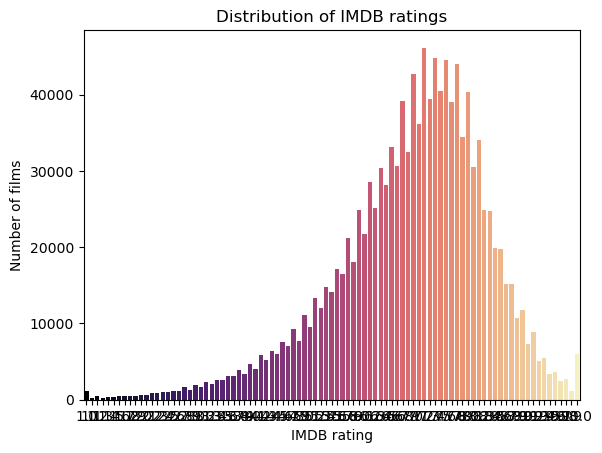

In [1510]:
_ = sns.countplot(x='averageRating', data=imdb, palette="magma") \
   .set(title='Distribution of IMDB ratings', xlabel='IMDB rating', ylabel='Number of films')

In [1511]:
C = imdb['averageRating'].mean()
m = imdb['numVotes'].min()
v = imdb['numVotes']
R = imdb['averageRating']

In [1512]:
imdb['WR'] = (v / (v + m)) * R + (m / (v + m)) * C # Complete original dataset


To check if the weighted rating has worked, we display below the best rated movie. We observe that for an IMDB rating of 9/10, the weighted rating WR is better for movies with the most votes. We conclude that this weighted rating is more representative of a movie' success.

In [1513]:
imdb[['originalTitle', 'averageRating', 'WR', 'numVotes']].sort_values('WR', ascending=False).head()

,originalTitle,averageRating,WR,numVotes
853340,Ozymandias,10.0,9.999918,185650
1000173,Unbreakable Souls,10.0,9.993245,2251
1023521,Angels Apocalypse,10.0,9.992627,2062
749029,Final Draft,10.0,9.978922,718
308511,Episode #1.9,10.0,9.975694,622


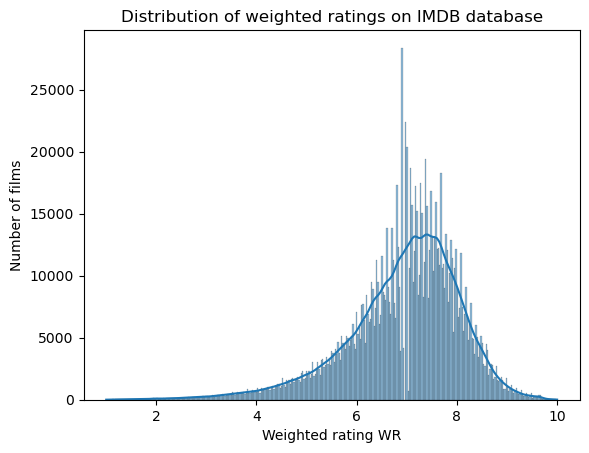

In [1514]:
_ = sns.histplot(x='WR', data=imdb, kde=True) \
   .set(title='Distribution of weighted ratings on IMDB database', xlabel='Weighted rating WR', ylabel='Number of films')

### Merge IMDB database with movie database to have common features

We would like to merge the data from CMU movies and IMDB top 1000. Since we don't want to reduce the size of data, we would rather to an outer merge and fill missing values with NaN.

In [1515]:
len((imdb['originalTitle'] + imdb['startYear'].astype(str)).unique()) / len(imdb)

0.9297141015371949

In [1516]:
imdb.drop_duplicates(subset=['originalTitle', 'startYear'], inplace=True)

In [1517]:
len((movies['name'] + movies['release_year'].astype(str)).unique()) / len(movies)

0.9977122863679182

In [1518]:
# Remove duplicated movie with video game
movies.drop(movies[movies['wikipedia_id'] == 3184269].index, inplace=True)
# Fix duplicated movie with changing it release year to the correct one based on its wikipedia page
movies.loc[movies['wikipedia_id'] == 25357930, ['release_year']] = "2010"

In [1519]:
movies.drop_duplicates(subset=['name', 'release_year'], inplace=True)

In [1520]:
imdb.rename({'originalTitle': 'name', 'startYear': 'release_year'}, axis=1, inplace=True)

In [1521]:
movies['release_year'] = movies['release_year'].replace('nan', np.nan).astype('float32')
movies['release_month'] = movies['release_month'].replace('nan', np.nan).astype('float32')
movies['release_day'] = movies['release_day'].replace('nan', np.nan).astype('float32')

In [1522]:
movie_feature = movies.merge(imdb, on=['name', 'release_year'], how='left')

In [1523]:
def fill_NaN(df, column_left, column_right, column_name=None): # Updates missing data from left column with right column data
    if column_name is None:
        column_name = column_left
    df[column_name] = df[column_left].fillna(df[column_right])

In [1524]:
fill_NaN(movie_feature, 'runtime', 'runtimeMinutes')
fill_NaN(movie_feature, 'genres_x', 'genres_y', 'genre')
movie_feature.drop(labels=['runtimeMinutes', 'genres_x', 'genres_y', 'primaryTitle', 'titleType', 'tconst', 'endYear'], axis=1, inplace=True)

In [1525]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'averageRating', 'numVotes', 'directors', 'writers',
       'WR', 'genre'],
      dtype='object')

In [1526]:
movie_feature.sample(3)

,wikipedia_id,freebase_id,name,box_office_revenue,runtime,languages,countries,release_year,release_month,release_day,averageRating,numVotes,directors,writers,WR,genre
65816,2040976,/m/06g_zh,American Pop,6000000.0,95.0,[English],[United States of America],1981.0,2.0,13.0,7.1,5040.0,[Ralph Bakshi],[Ronni Kern],7.099853,"[Jukebox musical, Indie, Animation, Musical, D..."
20807,31497189,/m/0glnqf4,Everything Is Rhythm,NaN,73.0,[English],[United Kingdom],1936.0,6.0,NaN,6.8,41.0,[Alfred J. Goulding],"[Jack Byrd, Syd Courtenay]",6.816531,[Musical]
60887,13374234,/m/03c37fl,I Live for Sex,NaN,73.0,[English],[United States of America],2007.0,NaN,NaN,5.5,24.0,"[Toby Ross, Joe Rubin]","[Toby Ross, Joe Rubin]",5.750360,"[Drama, Gay pornography]"


In [1527]:
movie_feature.describe()

,wikipedia_id,box_office_revenue,runtime,release_year,release_month,release_day,averageRating,numVotes,WR
count,8.155500e+04,8.392000e+03,67052.000000,74720.000000,42596.000000,39305.000000,44031.000000,4.403100e+04,44031.000000
mean,1.740360e+07,4.799791e+07,93.715766,1977.460815,6.692201,15.651240,6.195617,1.378128e+04,6.224498
std,1.098688e+07,1.122099e+08,60.342111,29.101585,3.483220,8.715734,1.155310,7.286329e+04,1.102334
min,3.300000e+02,1.000000e+04,0.000000,1010.000000,1.000000,1.000000,1.000000,5.000000e+00,1.131770
25%,7.320728e+06,2.075232e+06,80.000000,1956.000000,4.000000,8.000000,5.600000,1.070000e+02,5.614247
50%,1.777503e+07,1.063551e+07,93.000000,1985.000000,7.000000,16.000000,6.300000,5.160000e+02,6.317251
75%,2.714269e+07,4.073253e+07,108.000000,2004.000000,10.000000,23.000000,7.000000,2.660500e+03,6.998635
max,3.750192e+07,2.782275e+09,5700.000000,2016.000000,12.000000,31.000000,10.000000,2.667015e+06,9.467126


In [1528]:
print(f'There are {(imdb.shape[0]+movies.shape[0]) - movie_feature.shape[0]} common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes {imdb.shape[0]} elements and Movie corpus includes {movies.shape[0]}.')


There are 1165352 common elements to both IMDB and Movie Corpus datasets. Knowing that IMDB includes 1165352 elements and Movie corpus includes 81555.


In [1529]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'averageRating', 'numVotes', 'directors', 'writers',
       'WR', 'genre'],
      dtype='object')

[Text(0.5, 1.0, 'Distribution of weighted ratings on merged database'),
 Text(0.5, 0, 'Weighted rating WR'),
 Text(0, 0.5, 'Number of films')]

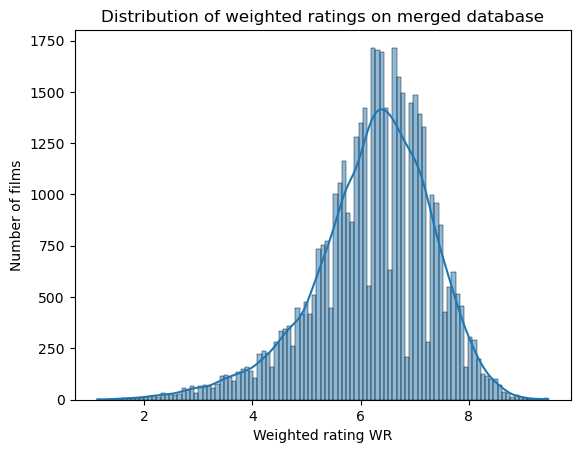

In [1530]:
sns.histplot(x='WR', data=movie_feature, kde=True).set(title='Distribution of weighted ratings on merged database',xlabel='Weighted rating WR', ylabel='Number of films')


In [1531]:
len((movie_feature['name'] + movie_feature['release_year'].astype(str)).unique()) / len(movie_feature)

1.0

### Fill missing budget data from imdb budget dataset

In [1532]:
imdb_budget.sample(5)

,Movie,Year,IMDb,Rating,Runtime,Genre,Release Date,Production Budget,Domestic Gross,Worldwide Gross
3257,PCU,1994,6.6,PG-13,79,Comedy,"Apr 29, 1994",9000000,4333569,4333569
38,Inside Out,2015,8.1,PG,95,"Animation, Adventure, Comedy","Jun 12, 2015",175000000,356461711,855210203
893,Dolphin Tale,2011,6.9,PG,113,"Drama, Family","Sep 23, 2011",37000000,72286779,96068724
1405,Killers,2010,5.5,PG-13,100,"Action, Comedy, Romance","Jun 4, 2010",75000000,47059963,95572749
2791,Ben-Hur: A Tale of the Christ,1925,7.8,Not Rated,143,"Adventure, Drama, Romance","Dec 30, 1925",3900000,9000000,9000000


In [1533]:
imdb_budget['Release Date'] = imdb_budget['Release Date'].astype('str') # Convert to string all dates
release_date = pd.DataFrame(pd.to_datetime(imdb_budget['Release Date']).apply(lambda x: [x.year, x.month, x.day]).tolist(), columns=['release_year','release_month','release_day'])
imdb_budget[['release_year','release_month','release_day']] = release_date

In [1542]:
imdb_budget['release_year'] = imdb_budget['release_year'].astype('float32')
imdb_budget['release_month'] = imdb_budget['release_month'].astype('float32')
imdb_budget['release_day'] = imdb_budget['release_day'].astype('float32')

In [1535]:
imdb_budget.drop(['Year', 'Release Date'], axis=1, inplace=True)
imdb_budget.rename({'Movie': 'name', 'Genre': 'genres'}, axis=1, inplace=True)
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [1536]:
imdb_budget['genres'] = imdb_budget['genres'].apply(lambda el: el.split(', '))

In [1543]:
imdb_budget.describe()

,IMDb,Runtime,Production Budget,Domestic Gross,Worldwide Gross,release_year,release_month,release_day
count,3828.000000,3828.000000,3.828000e+03,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000
mean,6.459013,109.940439,4.030960e+07,5.559021e+07,1.206910e+08,2003.593994,7.322100,15.891066
std,0.996623,20.219674,4.480927e+07,7.403263e+07,1.993646e+08,12.767752,3.378486,8.437509
min,1.500000,63.000000,7.000000e+03,0.000000e+00,0.000000e+00,1925.000000,1.000000,1.000000
25%,5.900000,96.000000,1.100000e+07,1.180967e+07,1.690363e+07,1999.000000,5.000000,9.000000
50%,6.500000,106.000000,2.500000e+07,3.225471e+07,5.077617e+07,2006.000000,8.000000,16.000000
75%,7.100000,120.000000,5.000000e+07,6.848642e+07,1.388776e+08,2013.000000,10.000000,23.000000
max,9.300000,271.000000,4.000000e+08,8.583730e+08,2.797801e+09,2020.000000,12.000000,31.000000


In [1544]:
len((movie_feature['name'] + str(movie_feature['release_year'])).unique()) / len(movie_feature)

0.9254858684323463

In [1539]:
imdb_budget.columns

Index(['name', 'IMDb', 'Rating', 'Runtime', 'genres', 'Production Budget',
       'Domestic Gross', 'Worldwide Gross', 'release_year', 'release_month',
       'release_day'],
      dtype='object')

In [1540]:
movie_feature.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month',
       'release_day', 'averageRating', 'numVotes', 'directors', 'writers',
       'WR', 'genre'],
      dtype='object')

In [1548]:
movie_feature_with_budget = movie_feature.merge(imdb_budget, on=['name', 'release_year'], how='outer')

In [1549]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'averageRating', 'numVotes', 'directors', 'writers',
       'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y'],
      dtype='object')

In [1551]:
fill_NaN(movie_feature_with_budget,'genre','genres','genre')
fill_NaN(movie_feature_with_budget,'release_day_x','release_day_y','release_day')
fill_NaN(movie_feature_with_budget,'release_month_x','release_month_y','release_month')
fill_NaN(movie_feature_with_budget,'runtime','Runtime')

KeyError: 'IMDB_Rating'

### Investigate the gross difference between the original and the imdb budget datasets

<AxesSubplot:title={'center':'Distribution of the difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

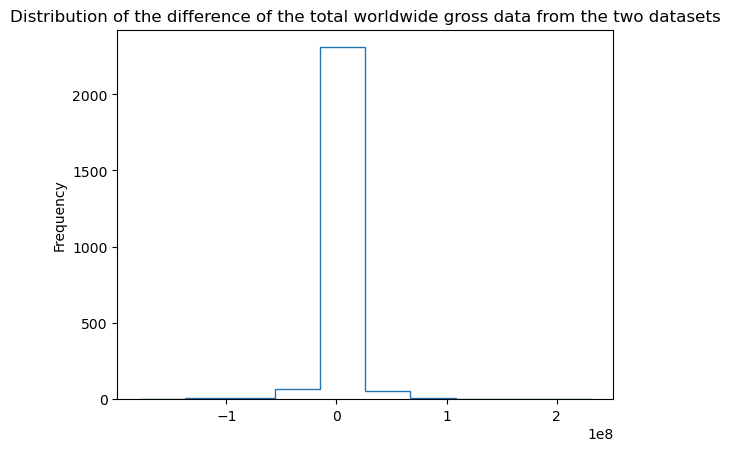

In [1552]:
(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']).plot(kind='hist', histtype='step', title='Distribution of the difference of the total worldwide gross data from the two datasets')

<AxesSubplot:title={'center':'Distribution of the percentage in difference of the total worldwide gross data from the two datasets'}, ylabel='Frequency'>

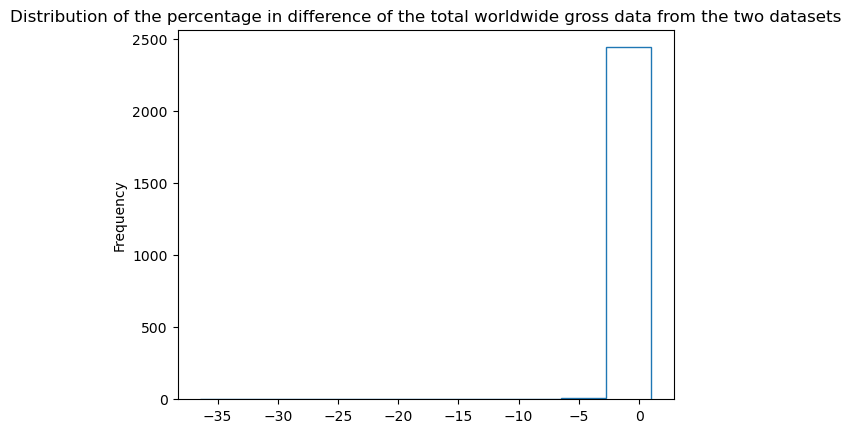

In [1553]:
((movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']).plot(kind='hist', histtype='step', title='Distribution of the percentage in difference of the total worldwide gross data from the two datasets')

In [1554]:
movie_feature_with_budget_differences = movie_feature_with_budget.copy()
movie_feature_with_budget_differences['gross_difference'] = np.abs(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'])
movie_feature_with_budget_differences['gross_difference%'] = ((np.abs(movie_feature_with_budget['box_office_revenue'] - movie_feature_with_budget['Worldwide Gross']) / movie_feature_with_budget['box_office_revenue']) * 100).round(2)

In [1555]:
# Difference between the total worldwide gross data from the two datasets
movie_feature_with_budget_differences \
    [(movie_feature_with_budget_differences['gross_difference'] != 0) & (~movie_feature_with_budget_differences['gross_difference'].isna())] \
    .sort_values('gross_difference%', ascending=False) \
    [['name', 'box_office_revenue', 'Worldwide Gross', 'gross_difference', 'gross_difference%']]

,name,box_office_revenue,Worldwide Gross,gross_difference,gross_difference%
1611,The Son of No One,30680.0,1148578.0,1117898.0,3643.74
10379,Restless,163265.0,2772511.0,2609246.0,1598.17
3307,Welcome to Collinwood,336620.0,4606284.0,4269664.0,1268.39
30129,Margaret,46495.0,623292.0,576797.0,1240.56
4126,The Wizard of Oz,3017000.0,34949482.0,31932482.0,1058.42
...,...,...,...,...,...
56979,Click,237681299.0,237685089.0,3790.0,0.00
57636,G-Force,292810686.0,292817841.0,7155.0,0.00
12989,What Women Want,374111707.0,374105123.0,6584.0,0.00
58624,Butch Cassidy and the Sundance Kid,102308889.0,102310653.0,1764.0,0.00


In [1556]:
# Percentage differences between the gross data from the two datasets
movie_feature_with_budget_differences.describe(percentiles=[.25, .5, .75, .8, .9, .95])[['gross_difference%']]

,gross_difference%
count,2464.000000
mean,16.458888
std,101.443043
min,0.000000
25%,0.020000
50%,0.695000
75%,5.455000
80%,9.924000
90%,34.167000
95%,62.882000


In [1557]:
movie_feature_with_budget_differences[movie_feature_with_budget_differences['gross_difference'] == 0].shape[0] / movie_feature_with_budget_differences['gross_difference%'].notna().sum()

0.15868506493506493

In [1558]:
movie_feature_with_budget_differences[
    (movie_feature_with_budget_differences['name'] == 'The Son of No One') |
    (movie_feature_with_budget_differences['name'] == 'Restless') |
    (movie_feature_with_budget_differences['name'] == 'Welcome to Collinwood')
][[
    'name', 'box_office_revenue', 'Worldwide Gross'
]]

,name,box_office_revenue,Worldwide Gross
1611,The Son of No One,30680.0,1148578.0
3307,Welcome to Collinwood,336620.0,4606284.0
10379,Restless,163265.0,2772511.0
18706,Restless,NaN,NaN
31576,Restless,NaN,NaN


In [1559]:
# gross_difference = box_office_revenue - Worldwide Gross
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] > 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] < 0).sum())
print((movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross'] == 0).sum())
(movie_feature_with_budget_differences['box_office_revenue'] - movie_feature_with_budget_differences['Worldwide Gross']).describe()

1012
1061
391


count    2.464000e+03
mean     4.148700e+05
std      1.570988e+07
min     -1.785914e+08
25%     -6.153875e+05
50%      0.000000e+00
75%      1.997022e+05
max      2.310745e+08
dtype: float64

We want to fill the missing data from the imdb budget dataset. For this purpose we are comparing the difference between the CMU, imdb top 1000, and imdb budget data. We have the:
 
 * `box_office_revenue` - from CMU with 8401 values /total gross/
 * `Gross` - from imdb top 1000 with 831 values /total gross in US and Canada/
 * `Domestic Gross` - from imdb budget with 3841 values /total gross in US and Canada/
 * `Worldwide Gross` - from imdb budget with 3841 values /total gross/

We would only consider the total worldwide gross since we are investigating movies from the whole world. The information for it is contained in the `box_office_revenue` and `Worldwide Gross`. Only around 20% of the values for the total gross are the same. Also, we know that the other data in `box_office_revenue` is not bigger or smaller than the `Worldwide Gross` for all records. So we can conclude that `box_office_revenue` and `Worldwide Gross` are not connected.

Based on this, we cannot combine the data from the both datasets and we would prefer using the data from the imdb budget dataset because it contains information about the budget of the movie and the data inside seams more accurate based on the comparison of a subset of it with Wikipedia data.

In [1560]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'averageRating', 'numVotes', 'directors', 'writers',
       'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [1564]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'box_office_revenue', 'runtime',
       'languages', 'countries', 'release_year', 'release_month_x',
       'release_day_x', 'averageRating', 'numVotes', 'directors', 'writers',
       'WR', 'genre', 'IMDb', 'Rating', 'Runtime', 'genres',
       'Production Budget', 'Domestic Gross', 'Worldwide Gross',
       'release_month_y', 'release_day_y', 'release_day', 'release_month'],
      dtype='object')

In [1567]:
# Remove merged extra columns 
movie_feature_with_budget.drop([
    'Worldwide Gross', 'Domestic Gross', 'Rating', 'Runtime', 'IMDb', 'release_month_x', 'release_month_y',
    'release_day_x', 'release_day_y', 'genres'
], axis=1, inplace=True)

# Rename gross column
movie_feature_with_budget.rename({'box_office_revenue': 'total_gross'}, axis=1, inplace=True)

# Compute profit as success indicator
movie_feature_with_budget['profit'] = movie_feature_with_budget['total_gross'] - movie_feature_with_budget['Production Budget']

In [1568]:
movie_feature_with_budget.columns

Index(['wikipedia_id', 'freebase_id', 'name', 'runtime', 'languages',
       'countries', 'release_year', 'averageRating', 'numVotes', 'directors',
       'writers', 'WR', 'genre', 'Production Budget', 'total_gross',
       'release_day', 'release_month', 'profit'],
      dtype='object')

In [1569]:
movie_feature_with_budget.describe()

,wikipedia_id,runtime,release_year,averageRating,numVotes,WR,Production Budget,total_gross,release_day,release_month,profit
count,8.155500e+04,68104.000000,75770.000000,44031.000000,4.403100e+04,44031.000000,3.828000e+03,3.828000e+03,40527.000000,43783.000000,3.828000e+03
mean,1.740360e+07,93.965487,1977.970337,6.195617,1.378128e+04,6.224498,4.030960e+07,1.206910e+08,15.658129,6.707717,8.038135e+07
std,1.098688e+07,59.949382,29.228281,1.155310,7.286329e+04,1.102334,4.480927e+07,1.993646e+08,8.708538,3.483055,1.696945e+08
min,3.300000e+02,0.000000,1010.000000,1.000000,5.000000e+00,1.131770,7.000000e+03,0.000000e+00,1.000000,1.000000,-1.580898e+08
25%,7.320728e+06,80.000000,1956.000000,5.600000,1.070000e+02,5.614247,1.100000e+07,1.690363e+07,8.000000,4.000000,-3.071668e+05
50%,1.777503e+07,93.000000,1986.000000,6.300000,5.160000e+02,6.317251,2.500000e+07,5.077617e+07,16.000000,7.000000,2.294270e+07
75%,2.714269e+07,108.000000,2004.000000,7.000000,2.660500e+03,6.998635,5.000000e+07,1.388776e+08,23.000000,10.000000,8.863580e+07
max,3.750192e+07,5700.000000,2020.000000,10.000000,2.667015e+06,9.467126,4.000000e+08,2.797801e+09,31.000000,12.000000,2.551701e+09


In [1570]:
movie_feature_with_budget.head(5)

,wikipedia_id,freebase_id,name,runtime,languages,countries,release_year,averageRating,numVotes,directors,writers,WR,genre,Production Budget,total_gross,release_day,release_month,profit
0,975900.0,/m/03vyhn,Ghosts of Mars,98.0,[English],[United States of America],2001.0,4.9,55353.0,[John Carpenter],"[Larry Sulkis, John Carpenter]",4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,NaN,24.0,8.0,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,95.0,[English],[United States of America],2000.0,NaN,NaN,NaN,NaN,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,16.0,2.0,NaN
2,28463795.0,/m/0crgdbh,Brun bitter,83.0,[Norwegian],[Norway],1988.0,5.7,40.0,[Sølve Skagen],"[Sølve Skagen, Gunnar Staalesen]",5.839121,"[Crime Fiction, Drama]",NaN,NaN,NaN,NaN,NaN
3,9363483.0,/m/0285_cd,White Of The Eye,110.0,[English],[United Kingdom],1987.0,NaN,NaN,NaN,NaN,NaN,"[Thriller, Erotic thriller, Psychological thri...",NaN,NaN,NaN,NaN,NaN
4,261236.0,/m/01mrr1,A Woman in Flames,106.0,[German],[Germany],1983.0,NaN,NaN,NaN,NaN,NaN,[Drama],NaN,NaN,NaN,NaN,NaN


## Account for inflation: 

As our movie database has movies dating back to 1921, we need to adjust the budgets and profits through an inflation rate.

Source: https://inflationdata.com/Inflation/Inflation/DecadeInflation.asp

In [1571]:
# Create dictionary of cumulative inflation rate per decade since 1913 in the US:
inflation_rates = [92.86, 4.82, -18.6, 68.57, 24.58, 28.23, 103.45, 64.41, 33.47, 28.31, 19.38, 1.27]
inflation_rates = [x / 100 + 1 for x in inflation_rates]
decades = list(np.linspace(1913,2023,len(inflation_rates)))
inflation_dic = dict(map(lambda i,j : (i,j) , decades, inflation_rates))

In [1572]:
df = movie_feature_with_budget.copy()

In [1573]:
# Initialisation
df['profit_modified'] = df['profit']
df['total_gross_modified'] = df['total_gross']
df['budget_modified'] = df['Production Budget']

In [1574]:
for k in range(len(decades)-1): # For each decade
    year_before = decades[k]
    year = decades[k+1]
    inflation_rate = inflation_dic[year_before]
    
    decade_df = df[(df['release_year']<year) & (df['release_year']>year_before)] # decade mask
    
    idx = decade_df.index.tolist()

    # Create new column with prices modified by interest rate
    df.loc[idx, 'profit_modified'] = decade_df['profit'] * inflation_rate
    df.loc[idx, 'total_gross_modified'] = decade_df['total_gross'] * inflation_rate
    df.loc[idx, 'budget_modified'] = decade_df['Production Budget'] * inflation_rate

In [1575]:
movie_feature_with_budget = df.copy()

In [1576]:
movie_feature_with_budget.head(2)

,wikipedia_id,freebase_id,name,runtime,languages,countries,release_year,averageRating,numVotes,directors,...,WR,genre,Production Budget,total_gross,release_day,release_month,profit,profit_modified,total_gross_modified,budget_modified
0,975900.0,/m/03vyhn,Ghosts of Mars,98.0,[English],[United States of America],2001.0,4.9,55353.0,[John Carpenter],...,4.900185,"[Thriller, Science Fiction, Horror, Adventure,...",NaN,NaN,24.0,8.0,NaN,NaN,NaN,NaN
1,3196793.0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,95.0,[English],[United States of America],2000.0,NaN,NaN,NaN,...,NaN,"[Mystery, Biographical film, Drama, Crime Drama]",NaN,NaN,16.0,2.0,NaN,NaN,NaN,NaN


In [1577]:
# Delete the columns for budget which are not modified by inflation rate: 
movie_feature_with_budget.drop(['total_gross','profit', 'Production Budget'], axis=1, inplace=True)

### Wikipedia pageviews

In [1578]:
wikipedia_pageviews.sample(5)

,name,pageviews
38082,Muchas gracias de nada,9.903656
43877,Pokémon: Lucario and the Mystery of Mew,4558.787220
12454,Colorado Territory,2482.616518
9285,Break,792.214262
59340,The Hound of the Deep,27.827734


In [1579]:
wikipedia_pageviews.describe()

,pageviews
count,6.758400e+04
mean,3.822596e+03
std,2.650207e+04
min,0.000000e+00
25%,4.189995e+01
50%,2.226739e+02
75%,1.155286e+03
max,5.154324e+06


In [1580]:
movie_feature_with_budget_and_wikipedia_pageviews = pd.merge(movie_feature_with_budget, wikipedia_pageviews, on='name', how='left')

In [1581]:
movie_feature_with_budget_and_wikipedia_pageviews.describe()

,wikipedia_id,runtime,release_year,averageRating,numVotes,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
count,8.155500e+04,68104.000000,75770.000000,44031.000000,4.403100e+04,44031.000000,40527.000000,43783.000000,3.828000e+03,3.828000e+03,3.828000e+03,7.330000e+04
mean,1.740360e+07,93.965487,1977.970337,6.195617,1.378128e+04,6.224498,15.658129,6.707717,1.022127e+08,1.531362e+08,5.092346e+07,5.087095e+03
std,1.098688e+07,59.949382,29.228281,1.155310,7.286329e+04,1.102334,8.708538,3.483055,2.118785e+08,2.474730e+08,5.505716e+07,5.753066e+04
min,3.300000e+02,0.000000,1010.000000,1.000000,5.000000e+00,1.131770,1.000000,1.000000,-1.887276e+08,0.000000e+00,8.981700e+03,0.000000e+00
25%,7.320728e+06,80.000000,1956.000000,5.600000,1.070000e+02,5.614247,8.000000,4.000000,-4.110680e+05,2.186877e+07,1.411410e+07,4.350988e+01
50%,1.777503e+07,93.000000,1986.000000,6.300000,5.160000e+02,6.317251,16.000000,7.000000,3.038498e+07,6.580837e+07,3.255200e+07,2.368342e+02
75%,2.714269e+07,108.000000,2004.000000,7.000000,2.660500e+03,6.998635,23.000000,10.000000,1.134723e+08,1.742421e+08,6.673500e+07,1.277118e+03
max,3.750192e+07,5700.000000,2020.000000,10.000000,2.667015e+06,9.467126,31.000000,12.000000,3.274088e+09,3.578183e+09,4.862949e+08,5.154324e+06


### Prepare `df_all`

In [1632]:
# For simplicity of use, we rename the dataframe
df_all = movie_feature_with_budget_and_wikipedia_pageviews

#### Deal with NaN

In [1665]:
fill_na_with_list(df_all, 'languages')
fill_na_with_list(df_all, 'countries')
fill_na_with_list(df_all, 'genre')
fill_na_with_list(df_all, 'directors')
fill_na_with_list(df_all, 'writers')

#### Remove irrelevant columns

In [1649]:
df_all.drop(['wikipedia_id', 'averageRating', 'numVotes'], axis=1, inplace=True)

#### One hot encoding for list values

In [1729]:
df_all_ohe = df_all.copy()

In [1728]:
def one_hot_encoding_list(df, column_name, top_count):
    top = pd.Series([el for _list in df[column_name] for el in _list]).value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda _list: [el if el in top else 'Other' for el in _list])
    result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
    result.fillna({f'{column_name}_{el}': 0 for el in list(top) + ['Other']}, inplace=True)
    result.drop([column_name], axis=1, inplace=True)
    return result

In [1730]:
def one_hot_encoding(df, column_name, top_count):
    top = df[column_name].value_counts()[:top_count].index
    df[column_name] = df[column_name].apply(lambda el: el if el in top else 'Other')
    result = df.join(pd.get_dummies(df[column_name], prefix=column_name).groupby(level=0).max())
    result.drop([column_name], axis=1, inplace=True)
    return result

In [1731]:
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'genre', 25)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'languages', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'countries', 15)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'directors', 30)
df_all_ohe = one_hot_encoding_list(df_all_ohe, 'writers', 30)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(df[column_name].apply(pd.Series).stack(), prefix=column_name).groupby(level=0).max())
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/142190017.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  result = df.join(pd.get_dummies(

#### Expand the list values

In [1735]:
df_all_expanded = df_all.copy()

In [1738]:
df_all_expanded = df_all_expanded.explode('genre')
df_all_expanded = df_all_expanded.explode('languages')
df_all_expanded = df_all_expanded.explode('countries')
df_all_expanded = df_all_expanded.explode('directors')
df_all_expanded = df_all_expanded.explode('writers')

In [1739]:
df_all_expanded.sample(5)

,freebase_id,name,runtime,languages,countries,release_year,directors,writers,WR,genre,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
60368,/m/0dr3sl,Shrek,92.0,English,Canada,2001.0,Andrew Adamson,Ted Elliott,7.899993,Animation,22.0,4.0,5.896875e+08,6.564225e+08,66735000.0,132789.496047
52255,/m/07s4nv0,Of Unknown Origin,88.0,English,United States of America,1983.0,George P. Cosmatos,Brian Taggert,6.101269,Horror,24.0,11.0,NaN,NaN,NaN,1582.471591
41769,/m/047rwtx,The Beautiful Blonde from Bashful Bend,77.0,English,United States of America,1949.0,Preston Sturges,Preston Sturges,6.005440,Comedy Western,NaN,NaN,NaN,NaN,NaN,464.144845
67255,/m/08s6mr,Fantastic Mr. Fox,88.0,French,United States of America,2009.0,Wes Anderson,Roald Dahl,7.899980,Comedy,23.0,10.0,9.088726e+06,6.041273e+07,51324000.0,126.690135
71043,/m/05stpm,Mission Kashmir,157.0,Urdu,India,2000.0,Vidhu Vinod Chopra,Abhijat Joshi,6.600242,Action/Adventure,27.0,10.0,NaN,NaN,NaN,14133.461957


For the final dataset obtained, we gather data from 4 different sources. In order to not restrain ourselves to only common features and end up with a smaller dataset, we made the choice of outer merges filled with NaN. Indeed, if we had taken inner merge of all datasets, it might be that our final dataset is both small and not badly representative of the population. 

Having NaN values has however some consequences on our data analysis. It might be that the NaN are not fully random, for instance, runtime for Crime movies are all missing values while we have the runtime for all Comedies. This should ideally be investigated further to check the NaN are indeed random. In the framework of this milestone, the choice was to focus on other tasks. We will thus assume randomness of NaN values.



# Exploratory Data Analysis

## Success indicators

Success of a movie can be very subjective. We thus need to diversify our definitions of success to have a holistic view of our dataset. The following success indicators are considered: 
- How well a movie is received: 
    IMDB ratings which should be weighted by the number of votes
- How profitable a movie is: 
    Overall gross revenue of the movie OR profit = gross revenue - budget spent
- How long a movie will last in time: 
    Number of connection to the movie wikipedia page


## Explore data

Looking at the impacts of features on eachother by drawing a correlation heatmap

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/2314911968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


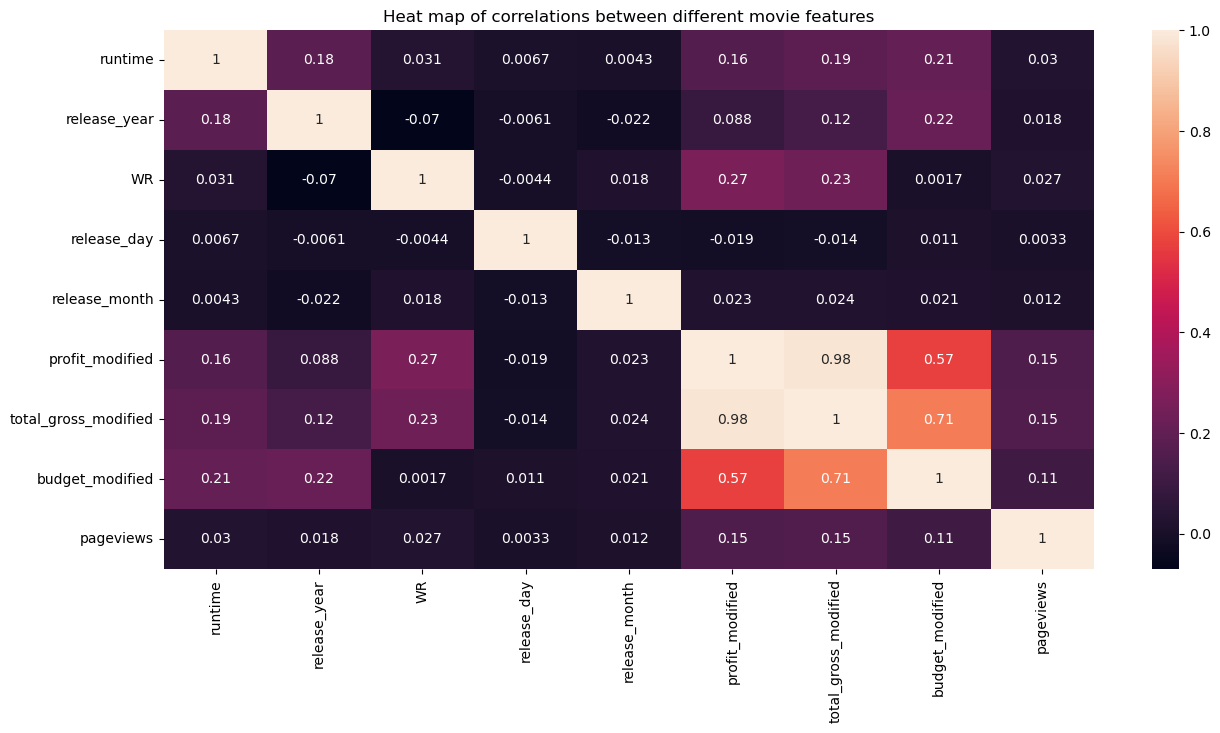

In [1740]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_all.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


Interesting correlations: 
- Our different success indicators are not too correlated (WR, profit_modified) 
- There is a correlation betweenn number of votes and profit 

### Impact of release date on success

To assess the impact of release date on success, we need to use the information on 'release_month' for each movie and need to choose a feature for success which can be either the IMDB weighted rating 'WR' or the gross revenue.

In [1584]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the release month information for {df_all['release_month'].count()} movies which is a big enough dataset to be representative.")

Out of 82605 movies in out dataset, we have the release month information for 43783 movies which is a big enough dataset to be representative.


In [1585]:
df_release = df_all.dropna(how='all', subset=['release_month']) # Remove NaN months

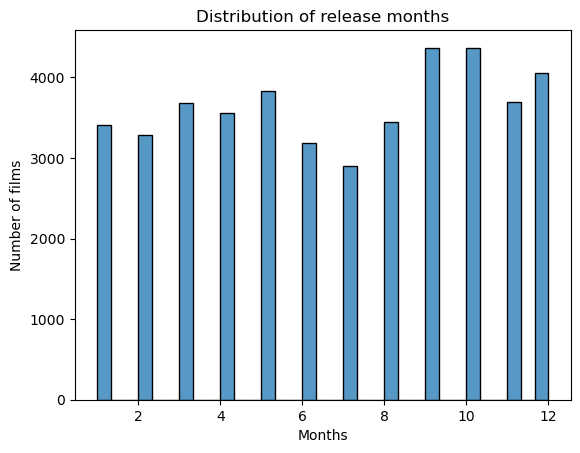

In [1586]:
sns.histplot(x='release_month', data = df_release).set(title='Distribution of release months',xlabel='Months', ylabel='Number of films');

From the plot above, we can see that the distribution of release months is fairly homogeneous accross the data which allows to investigate success accross different release months.

In [1587]:
df_release=df_release.sort_values(by='release_month', ascending=True)

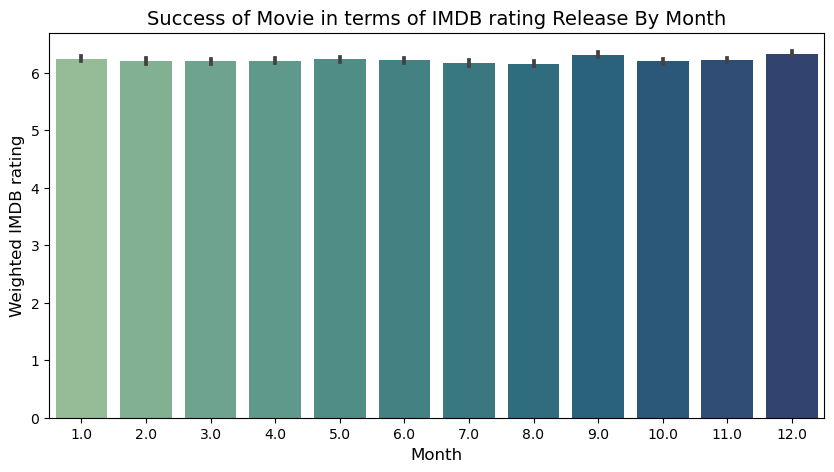

In [1588]:
# Plot
plt.figure(figsize=(10,5));
ax = sns.barplot(x="release_month", y="WR",data=df_release,palette='crest');
plt.xlabel('Month', fontsize=12)
plt.ylabel('Weighted IMDB rating', fontsize=12)
plt.title('Success of Movie in terms of IMDB rating Release By Month', fontsize=14);

Text(0.5, 1.0, 'Success in terms of revenue of Movie Release By Month')

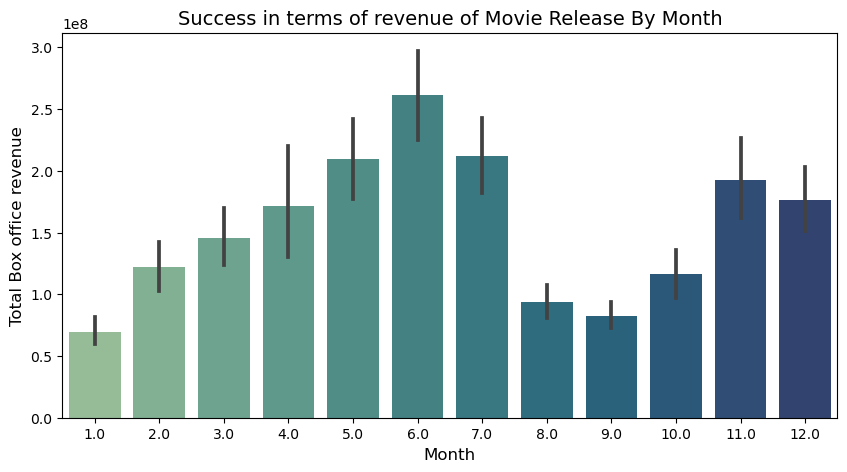

In [1589]:
# Plot
plt.figure(figsize=(10,5))
ax = sns.barplot(x="release_month", y="total_gross_modified",data=df_release,palette='crest')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Box office revenue', fontsize=12)
plt.title('Success in terms of revenue of Movie Release By Month', fontsize=14)

As we can see from the results above, the movie weighted ratings are not at all influenced by the release period. However, the gross revenue is. We see that movies released in summer and in the end of the year are more successful.  Since the distribution of movies is fairly the same across our dataset, we can deduce that these periods are more favourable for movie release. It interesting to note that these results coincide with usual holidays periods where people have more time to go to the cinema. 

## What budget should be spent on a successful movie?

To see what budget should be spent on a successful movie, we want to compare mainly three features, the budget spent 'Production Budget', the profit made 'profit' and the weighted rating of the movie to account for successfulness 'WR'.


In [1590]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the profit information for {df_all['profit_modified'].count()} movies, total gross revenue information for {df_all['total_gross_modified'].count()} movies , budget information for {df_all['budget_modified'].count()} movies.")


Out of 82605 movies in out dataset, we have the profit information for 3828 movies, total gross revenue information for 3828 movies , budget information for 3828 movies.


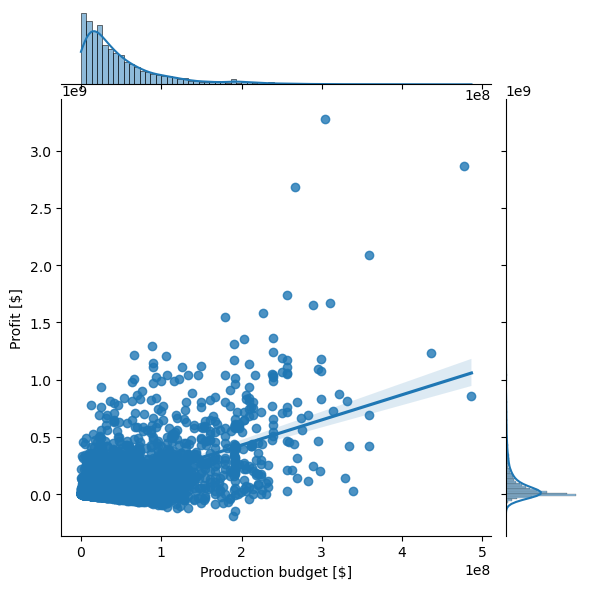

In [1591]:
h = sns.jointplot(data=df_all, x='budget_modified', y='profit_modified', kind="reg");
h.ax_joint.set_xlabel('Production budget [$]');
h.ax_joint.set_ylabel('Profit [$]');

As we can see from the plot above, the positive trend line indicates that an increase in the budget will result in an increase in profit. However, there seems to be a lot of outliers. For our datastory (Milestone 3), it would be interesting to split this into two categories, high budget movies and average movies. Additionnaly, we will want to investigate if this budget trend is different across genres.

To compare the link between all three features, we build the pairplot below:

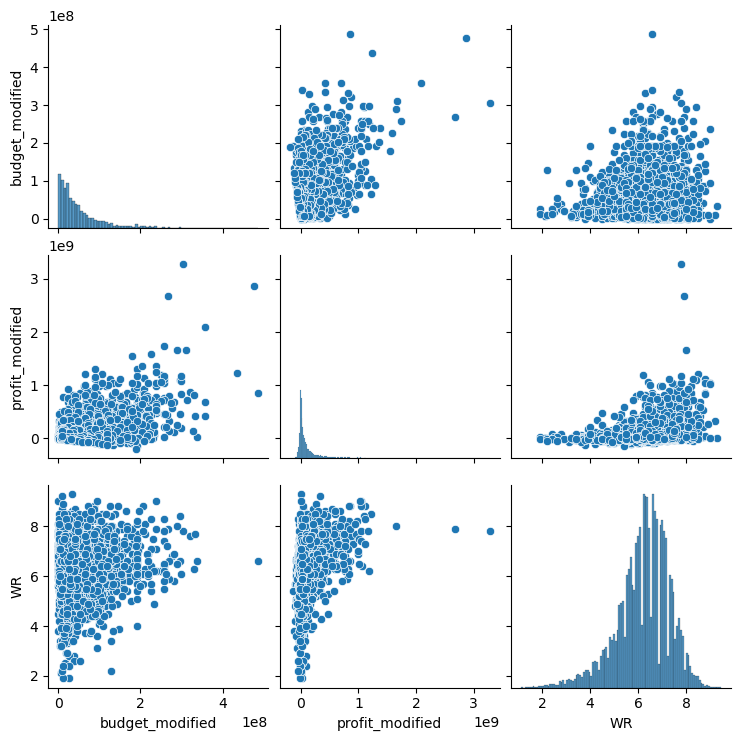

In [1592]:
sns.pairplot(movie_feature_with_budget[['budget_modified','profit_modified','WR']]);

### Top 20 most profitable movies

In [1742]:
Top20_ProfitableMovies = df_all.sort_values('profit_modified', ascending=False).head(20)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/3285713744.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'],
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/3285713744.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['budget_modified'],


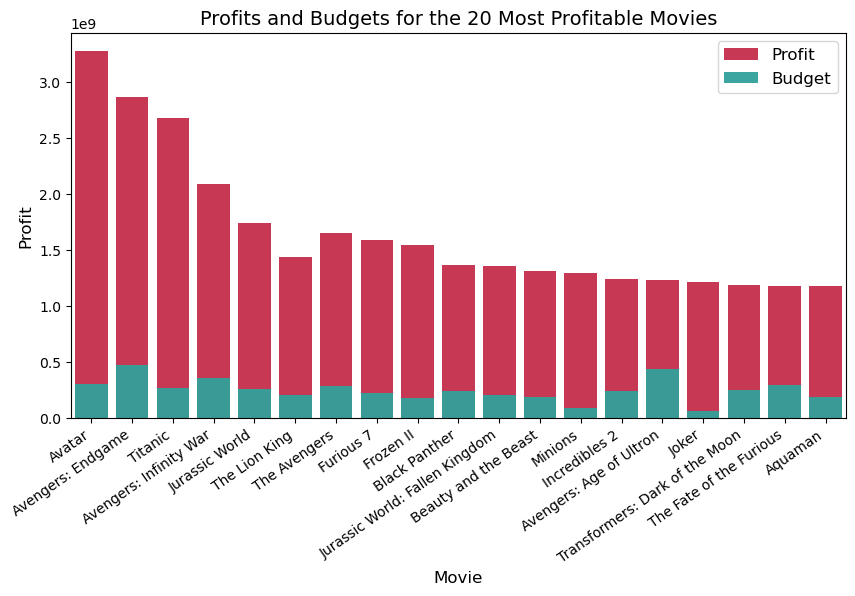

In [1743]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['name'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Movie', fontsize=12)
plt.title("Profits and Budgets for the 20 Most Profitable Movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

## Impact of director

In [1759]:
(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False

0        False
0         True
0         True
0         True
0         True
         ...  
82603     True
82603     True
82604    False
82604     True
82604     True
Length: 916591, dtype: bool

In [1760]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the director information for {df_all_expanded[(df_all_expanded['name'] + df_all_expanded['release_year'].astype('string')).duplicated() == False]['directors'].count()} movies coming from the IMDB data set.")

Out of 82605 movies in out dataset, we have the director information for 43724 movies coming from the IMDB data set.


In [1766]:
df_director = df_all_expanded.dropna(how='all', subset=['directors']).drop_duplicates(['name', 'release_year', 'directors']) # Remove NaN directors

In [1768]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/708278559.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['profit_modified'],
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/708278559.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['budget_modified'],


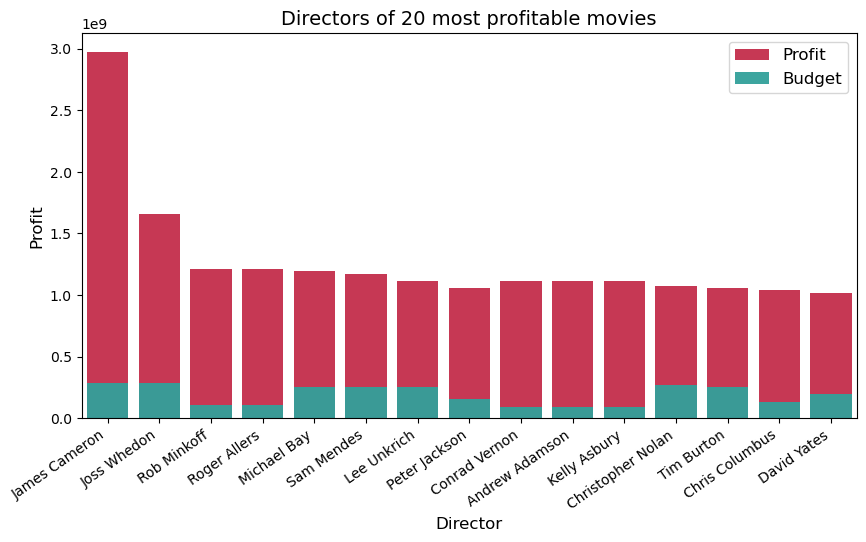

In [1769]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['directors'], y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [1770]:
Top20_ProfitableMovies['directors']

23686        James Cameron
22242        James Cameron
28169          Joss Whedon
21419          Rob Minkoff
21419         Roger Allers
18633          Michael Bay
78285           Sam Mendes
69462          Lee Unkrich
8815         Peter Jackson
59304        Conrad Vernon
59304       Andrew Adamson
59304         Kelly Asbury
54637    Christopher Nolan
9713            Tim Burton
65476        Peter Jackson
38115    Christopher Nolan
41152       Chris Columbus
79796        Peter Jackson
80736        Peter Jackson
17912          David Yates
Name: directors, dtype: object

## Impact of actors

In [1609]:
print(f"Out of {df_all.shape[0]} movies in out dataset, we have the 1st actor information for {df_all['Star1'].count()} movies coming from the top 1000 IMDB data set.")

KeyError: 'Star1'

For now, we only consider the main actor of a movie but this can be extrapolated to all actors accross multiple movies for our next milestone. 

In [ ]:
df_main_actor = df_all.dropna(how='all', subset=['Star1']) # Remove NaN actors

In [ ]:
Top20_ProfitableMovies = df_main_actor.sort_values('profit_modified', ascending=False).head(20)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/629570327.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'],
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/629570327.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['budget_modified'],


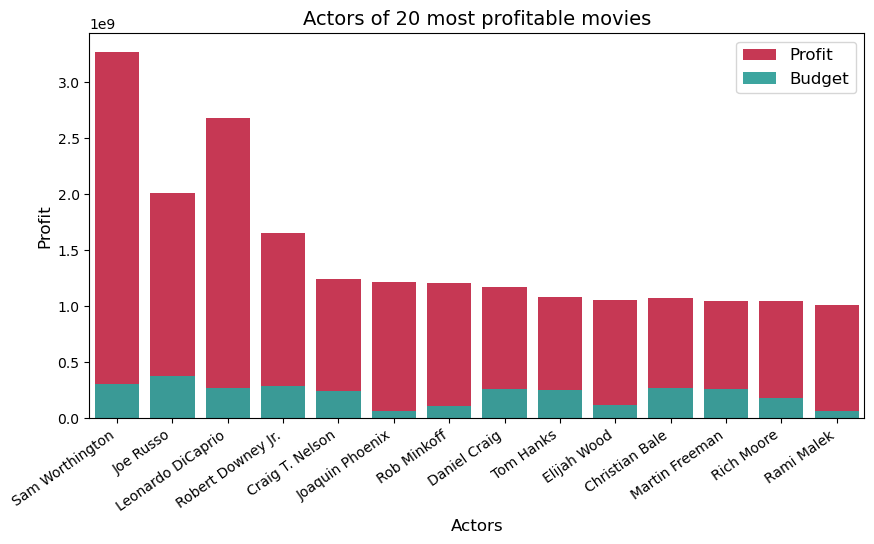

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Star1'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Actors', fontsize=12)
plt.title("Actors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

For our datastory, the goal would be to cluster actors accross genres. That way, we can forecast which actor would be best to select for a particular genre to boost success.

## Popular features in characters

The characters table is splitted between actors and actresses to study each gender as a whole different group.

In [1610]:
characters_male = characters[characters['actor_gender'] == 'M']
characters_female = characters[characters['actor_gender'] == 'F']

The following plot presents the height distribution for the actors and actresses. We can see that men tend to be taller than women actors. Also, it can be seen that in the dataset there are way more men than women

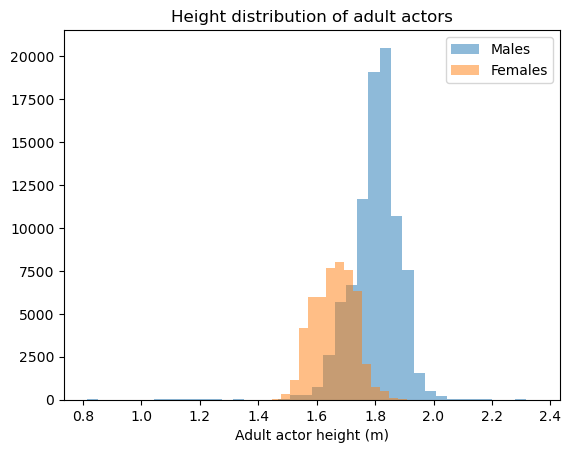

In [1611]:
def filter_children(characters):
    LIMIT_CHILDREN_AGE = 14
    return characters[(characters['actor_age_at_movie_release'] > LIMIT_CHILDREN_AGE)]

def characters_height_histogram(characters, bins):
    characters_height = characters.dropna(subset=['actor_height_meters'])
    plt.hist(characters_height['actor_height_meters'],bins=bins, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Adult actor height (m)')
    plt.title('Height distribution of adult actors')

characters_height_histogram(filter_children(characters_male), bins=40)
characters_height_histogram(filter_children(characters_female), bins=25)


Another important characteristic we can study is the age on movie release. Again, there is a huge difference between women and men. Women play roles when they are younger, while men seem to have longer careers.

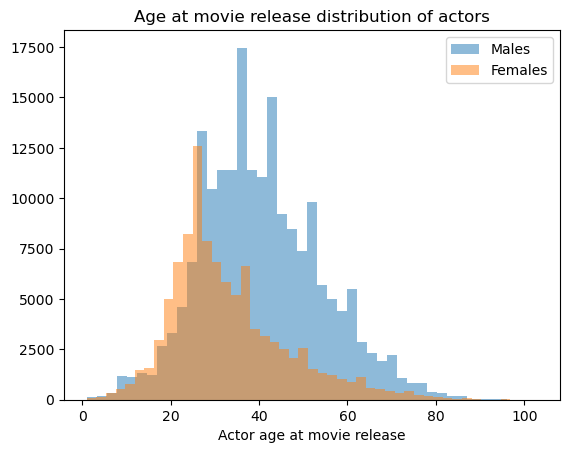

In [1612]:
def characters_age_histogram(characters):
    characters_age = characters.dropna(subset=['actor_age_at_movie_release']).sort_values(by=['actor_age_at_movie_release'])
    characters_age = characters_age[characters_age['actor_age_at_movie_release'] > 0]
    plt.hist(characters_age['actor_age_at_movie_release'], bins=45, alpha=0.5)
    plt.legend(['Males', 'Females'])
    plt.xlabel('Actor age at movie release')
    plt.title('Age at movie release distribution of actors')

characters_age_histogram(characters_male)
characters_age_histogram(characters_female)

The following plot shows the ethnicity distribution for actors and actresses of the dataset. It can be seen how white people clearly dominate the characters dataset by more than a half of it. Indians are also a big group representing 1/4 of the ethnicities. In this case, the difference between genders is not that big.

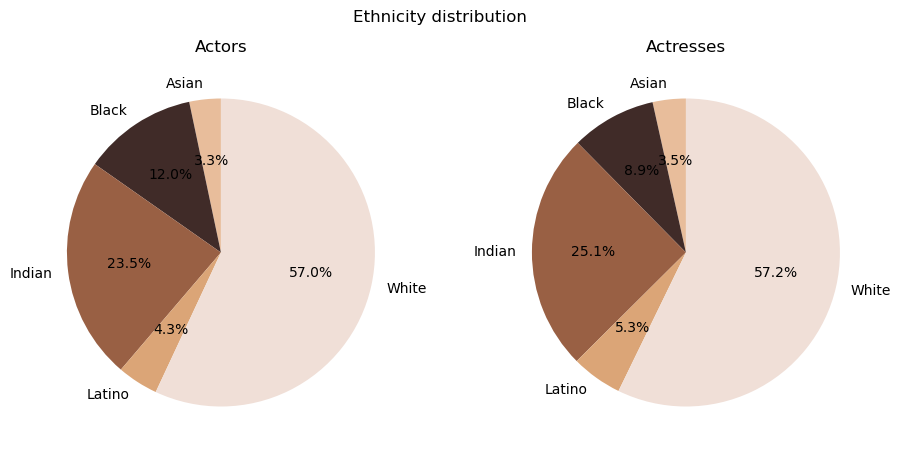

In [1613]:
def pie_chart_actor_ethnicities(actors, title, ax):
    actors_ethnicity = actors.dropna(subset=['major_ethnicity'])
    actors_ethnicity = actors_ethnicity[actors_ethnicity['major_ethnicity'] != 'unknown']
    ethnicities, counts = np.unique(actors_ethnicity['major_ethnicity'], return_counts=True)
    #print(np.sort(counts))
    others_count = 0
    plot_ethnicities = []
    plot_counts = []
    ETHNICITY_THRESHOLD = 1
    for ethnicity, count in zip(ethnicities, counts):
        if count > ETHNICITY_THRESHOLD:
            plot_ethnicities.append(ethnicity)
            plot_counts.append(count)
        else:
            others_count += count

    colors = ['#e8bd9b','#402b28','#996044','#dba577','#f0dfd7']

    ax.pie(plot_counts, labels=plot_ethnicities, startangle=90,autopct='%1.1f%%',colors=colors, radius=1)
    ax.set_title(title)

def two_pie_charts_actor_ethnicities(actors1, actors2, title, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_facecolor('white')
    fig.set_size_inches(11, 5)
    fig.suptitle(title)

    pie_chart_actor_ethnicities(actors1, title1, ax1)
    pie_chart_actor_ethnicities(actors2, title2, ax2)
    plt.show()


two_pie_charts_actor_ethnicities(characters_male, 
                                 characters_female, 
                                 title='Ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

The next plot shows the number of different ethnicities per movie. For instance, a movie that includes at least one Indian and one Black actress has 2 different ethnicities. As we can see, the vast majority of the films only have one ethnicity on it.

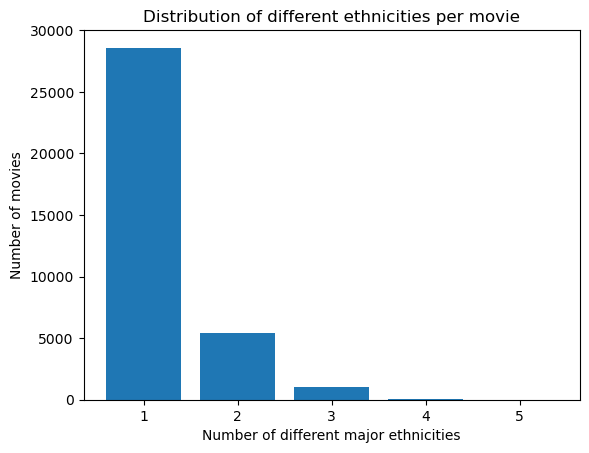

In [1614]:
def plot_different_ethnicities_per_movie(characters):
    ethnicity_characters = characters.dropna(subset=['major_ethnicity'])
    num_different_ethnicities = ethnicity_characters.groupby(by=['freebase_movie_id'])['major_ethnicity'].nunique()
    num_ethnicies, count = np.unique(num_different_ethnicities, return_counts=True)
    plt.bar(num_ethnicies, count)
    plt.xlabel('Number of different major ethnicities')
    plt.ylabel('Number of movies')
    plt.title('Distribution of different ethnicities per movie')
plot_different_ethnicities_per_movie(characters)

Since now, we have been working using all the characters in the dataset, even if the same actor played more than one. Now, let's focus on actors instead of characters to figure out the success associated to the professional. First we create an actors dataset. We also compute in how many films in the dataset the actor appears, this value can be found in the column `num_movies`

In [1615]:
actors = characters[['freebase_actor_id', 'freebase_movie_id', 'actor_name', 'actor_gender', 'actor_height_meters', 'ethnicity_label', 'major_ethnicity']]
actors = actors.dropna(subset=['freebase_actor_id'])
actors['num_movies'] = actors.groupby(by=['freebase_actor_id'])['freebase_actor_id'].transform('size')
actors.drop('freebase_movie_id', axis=1, inplace=True)
actors.drop_duplicates(subset=['freebase_actor_id'], inplace=True)
actors.head(5)

,freebase_actor_id,actor_name,actor_gender,actor_height_meters,ethnicity_label,major_ethnicity,num_movies
0,/m/03wcfv7,Wanda De Jesus,F,1.620,NaN,NaN,8
1,/m/0346l4,Natasha Henstridge,F,1.780,unknown,NaN,23
2,/m/01vw26l,Ice Cube,M,1.727,African Americans,Black,33
3,/m/034hyc,Jason Statham,M,1.750,NaN,NaN,31
4,/m/01y9xg,Clea DuVall,F,1.650,NaN,NaN,31


Again, let's split actors in genders

In [1616]:
actors_male = actors[actors['actor_gender'] == 'M']
actors_female = actors[actors['actor_gender'] == 'F']

And now we can focus on the actors that have appeared in a greater number of movies. We fix this threshold at 15 movies.

In [1617]:
def get_most_demanded_actors(actors, min_num_movies):
    return actors[actors['num_movies'] >= min_num_movies]

MIN_NUM_MOVIES_DEMANDED_ACTOR = 15
demanded_actors_male = get_most_demanded_actors(actors_male, MIN_NUM_MOVIES_DEMANDED_ACTOR)
demanded_actors_female = get_most_demanded_actors(actors_female, MIN_NUM_MOVIES_DEMANDED_ACTOR)


This way, we can compare if the most characteristic features of each actor are the same for the whole dataset of characters. We are plotting again the height distribution both for males and females.

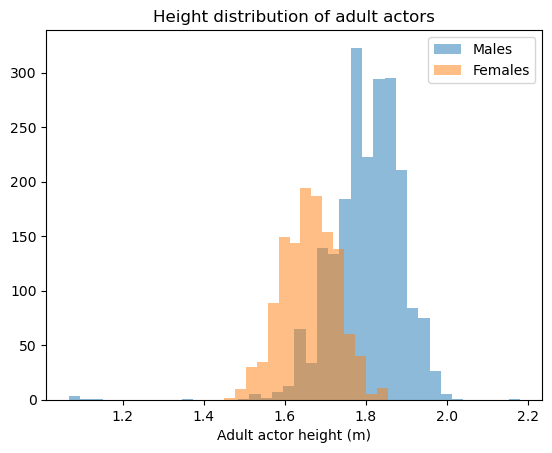

In [1618]:
characters_height_histogram(demanded_actors_male, 40)
characters_height_histogram(demanded_actors_female, 15)

Also, the ethnicities are plotted again. We can observe that discriminations are even bigger.

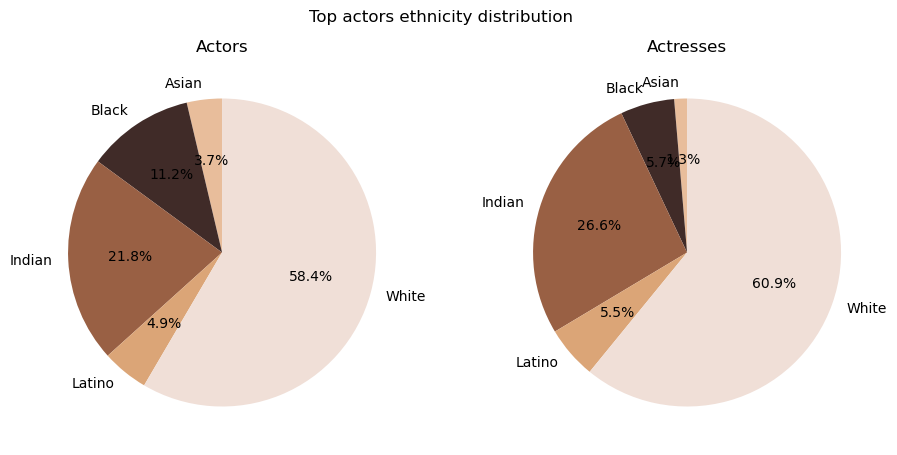

In [1619]:
two_pie_charts_actor_ethnicities(demanded_actors_male, 
                                 demanded_actors_female, 
                                 title='Top actors ethnicity distribution', 
                                 title1='Actors', 
                                 title2='Actresses')

All these data about characters is going to be merged and analysed for the last milestone. By now, we have demonstrated that we have data enough to work and answer the proper questions

## What genres are the most profitable?

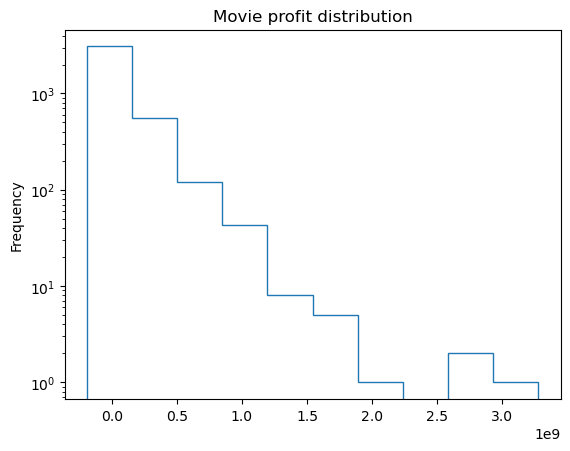

In [1771]:
df_all['profit_modified'].plot(kind='hist', logy=True, histtype='step', title='Movie profit distribution');

In [1773]:
df_genre = df_director = df_all_expanded.dropna(how='all', subset=['genre']).drop_duplicates(['name', 'release_year', 'genre'])

In [1776]:
genres = df_genre['genre'].value_counts()

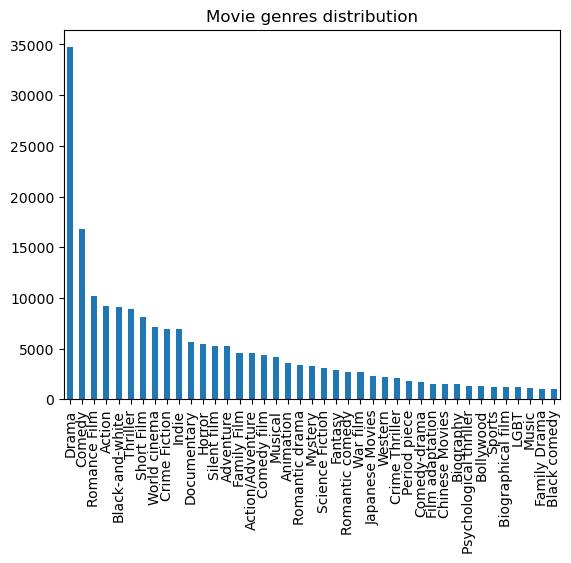

In [1781]:
genres[genres > 1000].plot(kind='bar', title='Movie genres distribution');

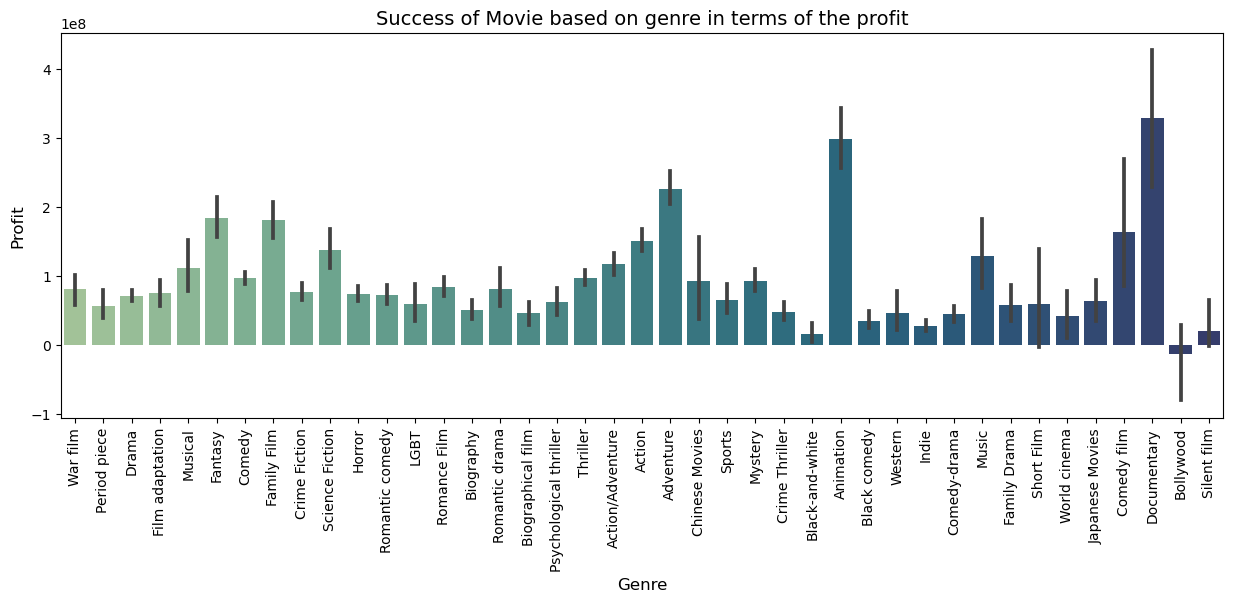

In [1783]:
plt.figure(figsize=(15,5));
ax = sns.barplot(
    x="genre",
    y="profit_modified",
    data=df_genre[df_genre['profit_modified'].notna() & df_genre['genre'].isin(genres[genres > 1000].index.to_list())],
    palette='crest'
)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Profit', fontsize=12)
plt.title('Success of Movie based on genre in terms of the profit', fontsize=14)
_ = plt.xticks(rotation=90)

## Correlation between the choice of topics and movie profitability can be investigated

In [1785]:
df_genre['genre_category'] = df_genre['genre'].astype('category').cat.codes

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/1060159001.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_genre.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');


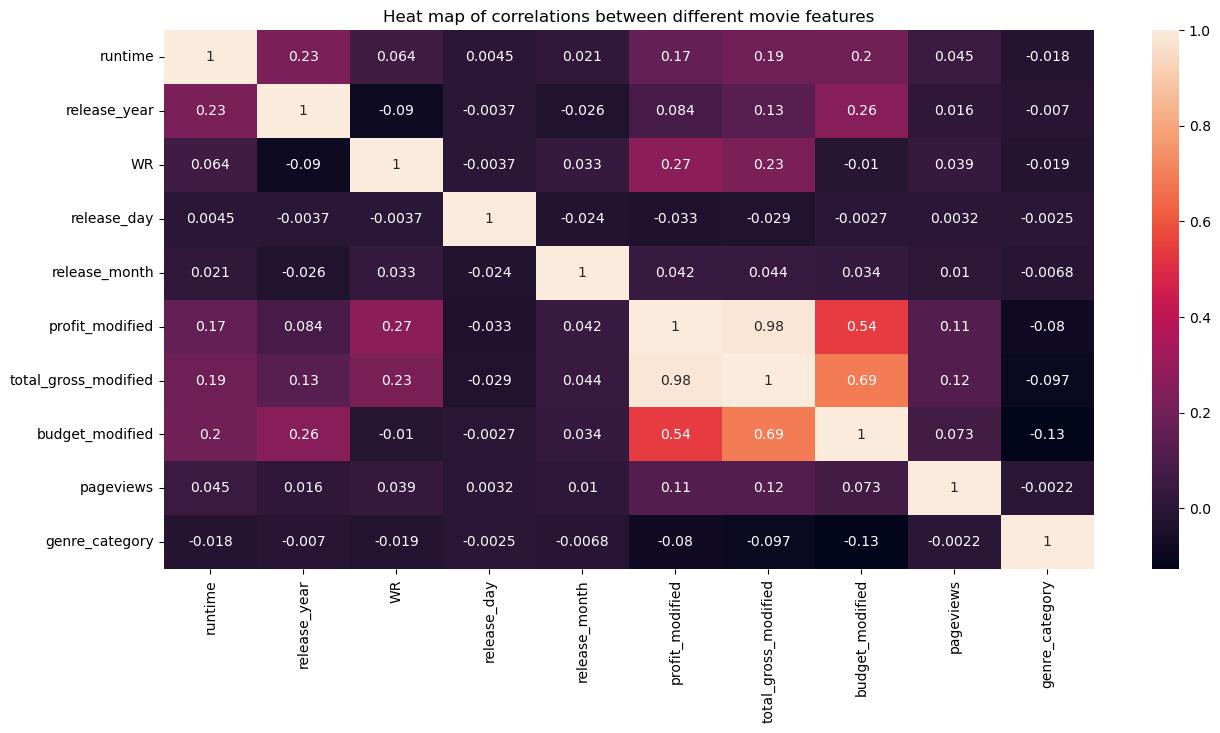

In [1786]:
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_genre.corr(), annot=True, ax=ax).set(title='Heat map of correlations between different movie features');

## Clustering between movies: Classics VS forgettable : check with wikipedia ID how much it is visited : time series of access 

In [1787]:
wikipedia_pageviews.sample(5)

,name,pageviews
49769,Shivering Sherlocks,330.879447
46222,Rendu Rella Aaru,336.796031
68461,Tuya's Marriage,264.188241
28321,Jersey Girl,84.645916
52394,Strange Illusion,456.888587


In [1789]:
df_all_ohe.sample(5)

,freebase_id,name,runtime,release_year,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,...,writers_Paruchuri Venkateswara Rao,writers_Rahi Masoom Reza,writers_Robert A. McGowan,writers_Sachin Bhowmick,writers_Satyanand,writers_Stephen King,writers_Tedd Pierce,writers_Val Guest,writers_Warren Foster,writers_William Shakespeare
16252,/m/0ch4s96,Zion and His Brother,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41484,/m/04184fz,Hormones,NaN,2008.0,NaN,20.0,3.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36743,/m/07k96sv,South American George,92.0,1941.0,6.043277,27.0,12.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62970,/m/06jst9,Killadelphia,180.0,2005.0,NaN,21.0,6.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,/m/0j3g8w0,Lovely,139.0,2012.0,5.346407,30.0,3.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1816]:
df_all_ohe_cleaned_columns = df_all_ohe.rename({c: c.replace('/', '').replace('.', '').replace(' ', '').replace('\'', '').replace('-', '') for c in df_all_ohe.columns}, axis=1)

In [1818]:
mod = smf.ols(formula=
    'pageviews ~ runtime + release_year + WR + release_month + profit_modified + genre_Action + ' +
    'genre_ActionAdventure + genre_Adventure + genre_Animation + genre_Blackandwhite + genre_Comedy + ' +
    'genre_Comedyfilm + genre_CrimeFiction + genre_Documentary + genre_Drama + genre_FamilyFilm + ' + 
    'genre_Fantasy + genre_Horror + genre_Indie + genre_Musical + genre_Mystery + genre_Other + ' + 
    'genre_RomanceFilm + genre_Romanticcomedy + genre_Romanticdrama + genre_ScienceFiction + genre_ShortFilm + ' + 
    'genre_Silentfilm + genre_Thriller + genre_Warfilm + genre_Worldcinema + languages_Cantonese + ' + 
    'languages_English + languages_French + languages_German + languages_Hindi + languages_Italian + ' + 
    'languages_Japanese + languages_Korean + languages_Malayalam + languages_Other + languages_Russian + ' + 
    'languages_Silentfilm + languages_Spanish + languages_StandardMandarin + languages_Tamil + languages_Telugu + ' + 
    'countries_Argentina + countries_Australia + countries_Canada + countries_France + countries_Germany + ' + 
    'countries_HongKong + countries_India + countries_Italy + countries_Japan + countries_Mexico + ' + 
    'countries_Netherlands + countries_Other + countries_SouthKorea + countries_Spain + countries_UnitedKingdom + ' + 
    'countries_UnitedStatesofAmerica + directors_AlfredHitchcock + directors_CecilBDeMille + ' + 
    'directors_CharlesChaplin + directors_CharlesLamont + directors_ChuckJones + directors_DWGriffith + ' + 
    'directors_DaveFleischer + directors_FrizFreleng + directors_GeorgeCukor + directors_GeorgeMarshall + ' + 
    'directors_GordonDouglas + directors_HenryHathaway + directors_JohnFord + directors_JosephBarbera + ' + 
    'directors_JosephKane + directors_JulesWhite + directors_MichaelCurtiz + directors_NormanTaurog + ' + 
    'directors_Other + directors_RaoulWalsh + directors_RayTaylor + directors_RichardThorpe + directors_RobertFMcGowan + ' + 
    'directors_RobertFlorey + directors_RobertMcKimson + directors_RoscoeFattyArbuckle + directors_SamNewfield + ' + 
    'directors_WilliamAWellman + directors_WilliamBeaudine + directors_WilliamHanna + directors_WilliamWitney + ' + 
    'writers_ArthurConanDoyle + writers_BasilDickey + writers_BenHecht + writers_CareyWilson + writers_CharlesChaplin + ' + 
    'writers_CharlesDickens + writers_DWGriffith + writers_DudleyNichols + writers_EdgarRiceBurroughs + writers_ElwoodUllman + ' + 
    'writers_FelixAdler + writers_FrancesMarion + writers_GeorgeHPlympton + writers_GopalakrishnaParuchuri + writers_HMWalker + ' + 
    'writers_HalRoach + writers_JohnWDunn + writers_KaderKhan + writers_MichaelMaltese + writers_NunnallyJohnson + writers_Other + ' + 
    'writers_ParuchuriVenkateswaraRao + writers_RahiMasoomReza + writers_RobertAMcGowan + writers_SachinBhowmick + writers_Satyanand + ' + 
    'writers_StephenKing + writers_TeddPierce + writers_ValGuest + writers_WarrenFoster + writers_WilliamShakespeare',
  data=df_all_ohe_cleaned_columns)
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              pageviews   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     6.502
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           8.05e-57
Time:                        18:59:01   Log-Likelihood:                -35332.
No. Observations:                2738   AIC:                         7.082e+04
Df Residuals:                    2660   BIC:                         7.128e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                         8.983e+05   3.96e+05      2.269      0.023    1.22e+05    1.67e+06
runtime                            337.3815     76.495      4.411      0.000     187.386     487.377
release_year                      -445.0720    192.844     -2.308      0.021    -823.211     -66.933
WR                                3591.9942   2419.684      1.484      0.138   -1152.658    8336.646
release_month                    -1080.1634    569.195     -1.898      0.058   -2196.272      35.945
profit_modified                   5.495e-05   1.16e-05      4.722      0.000    3.21e-05    7.78e-05
genre_Action                      -854.4379   6449.331     -0.132      0.895   -1.35e+04    1.18e+04
genre_ActionAdventure            -5350.2661   6763.663     -0.791      0.429   -1.86e+04    7912.304
genre_Adventure                  -1814.8304   5964.163     -0.304      0.761   -1.35e+04    9880.036
genre_Animation                   7209.2642   1.08e+04      0.667      0.505    -1.4e+04    2.84e+04
genre_Blackandwhite              -5.853e+04   1.97e+04     -2.978      0.003   -9.71e+04      -2e+04
genre_Comedy                      3586.7361   5243.485      0.684      0.494   -6694.984    1.39e+04
genre_Comedyfilm                 -2676.0274   1.99e+04     -0.134      0.893   -4.18e+04    3.64e+04
genre_CrimeFiction                3666.4905   5624.141      0.652      0.515   -7361.642    1.47e+04
genre_Documentary                 1.337e+04   5.75e+04      0.232      0.816   -9.95e+04    1.26e+05
genre_Drama                      -8929.5914   4997.480     -1.787      0.074   -1.87e+04     869.748
genre_FamilyFilm                 -1459.5277   7653.163     -0.191      0.849   -1.65e+04    1.35e+04
genre_Fantasy                      571.9919   6342.447      0.090      0.928   -1.19e+04     1.3e+04
genre_Horror                      7979.2420   7036.839      1.134      0.257   -5818.987    2.18e+04
genre_Indie                       5342.2110   6633.910      0.805      0.421   -7665.932    1.84e+04
genre_Musical                      439.9273   9375.536      0.047      0.963   -1.79e+04    1.88e+04
genre_Mystery                    -2819.9829   7063.513     -0.399      0.690   -1.67e+04     1.1e+04
genre_Other                       2824.0796   5350.047      0.528      0.598   -7666.593    1.33e+04
genre_RomanceFilm                 2146.7931   7036.113      0.305      0.760   -1.17e+04    1.59e+04
genre_Romanticcomedy             -1.121e+04   8656.061     -1.295      0.195   -2.82e+04    5764.074
genre_Romanticdrama                2.02e+04   8911.372      2.267      0.023    2730.252    3.77e+04
genre_ScienceFiction              9201.5027   6360.687      1.447      0.148   -3270.891    2.17e+04
genre_ShortFilm                  -3337.8538   3.55e+0

## Countries

In [ ]:
# sort by country
import json
movies_header = ['wikipedia_id', 'freebase_id', 'name', 'release_date', 'box_office_revenue', 'runtime', 'languages', 'countries', 'genres']
movies = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
data = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None, names=movies_header)
movies.head(5)
print(movies.shape)
# movies=movies['countries'].apply(lambda row: len((eval(row).values())))
movies=movies['countries'].apply(lambda row: (eval(row).values()))
movies= pd.DataFrame(movies,columns=['countries'])
# movies['countries'].apply(len)
# movies.describe()
movies.head()


(81741, 9)


,countries
0,(United States of America)
1,(United States of America)
2,(Norway)
3,(United Kingdom)
4,(Germany)


In [ ]:


# movies=movies['countries'].apply(lambda row: (eval(row).values()))
# movies= pd.DataFrame(movies,columns=['countries'])
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('test.csv')
# US=movies['countries'].apply(lambda lis : "United States of America" in lis and len(lis)==1)
US=movies['countries'].apply(lambda lis : "United States of America" in lis)
US_movies=data.loc[US]
print('number of movies made in the US: ',US.sum())
IN=movies['countries'].apply(lambda lis : "India" in lis)
IN_movies=movies[IN]
print('number of movies made in india: ',IN.sum())

mult=movies['countries'].apply(lambda lis : len(lis)>1)
print('number of movies made in more than one country: ',sum(mult))


number of movies made in the US:  34408
number of movies made in india:  8411
number of movies made in more than one country:  9218


In [ ]:

# one list with all the countries of all the movies
exploded=pd.DataFrame([[c] for C in movies['countries'] for c in C],columns=['countries'])
len(exploded['countries'].unique())
count=exploded['countries'].value_counts()
count.to_csv('handled_data/test.csv')


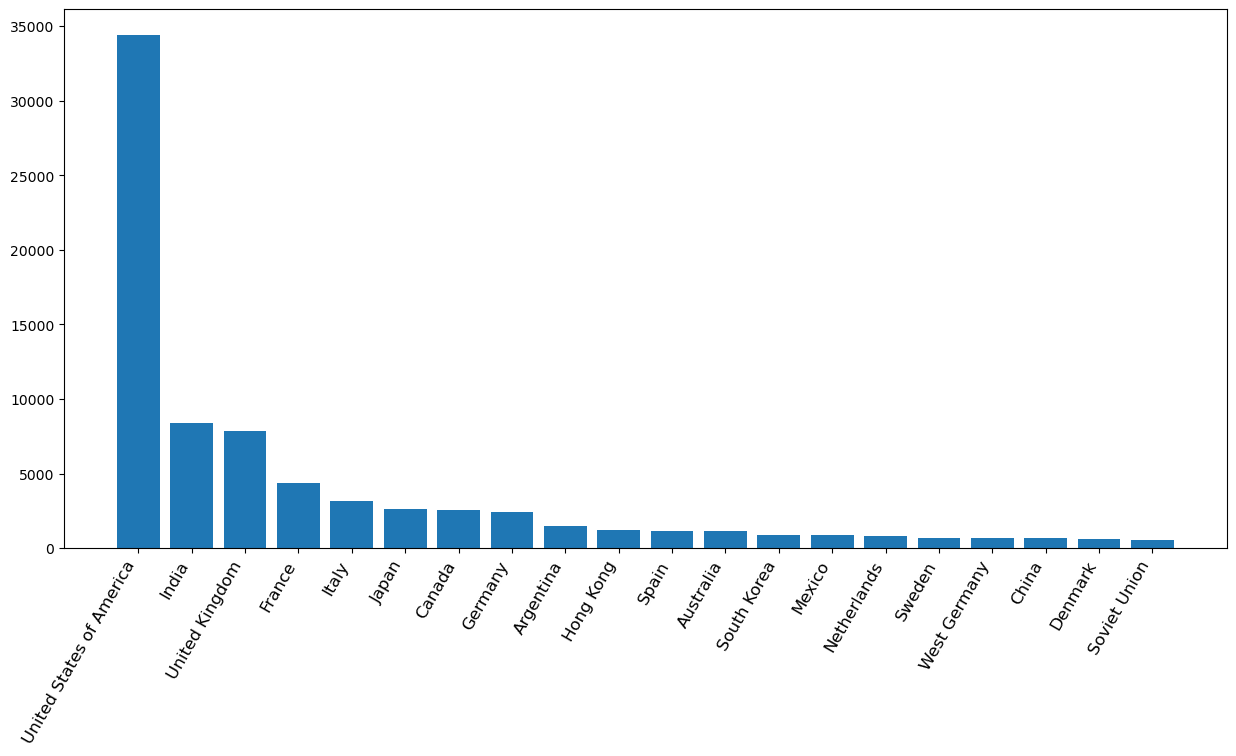

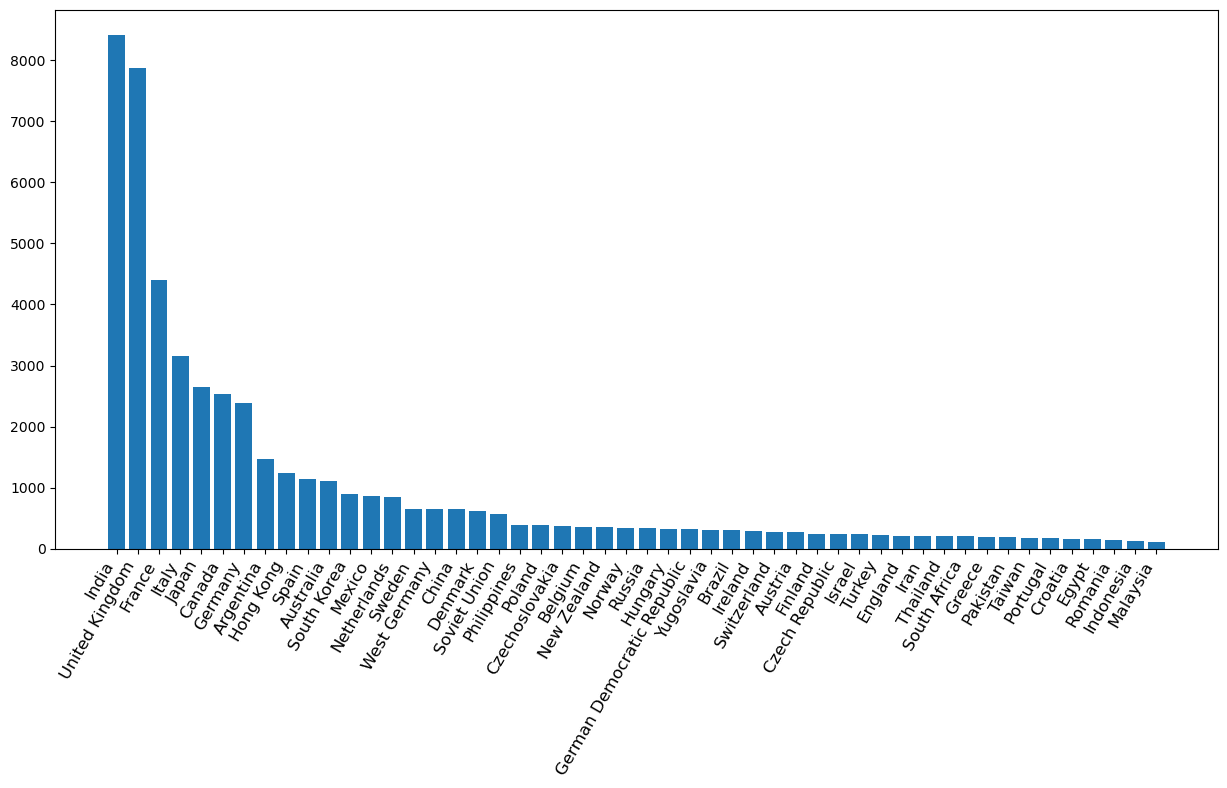

In [ ]:



from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count.head(20).index.to_series(),count.head(20))
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,7))
plt.bar(count[1:51].index.to_series(),count[1:51])
plt.xticks(rotation=60, horizontalalignment='right', fontsize=12);


In [ ]:


# sort movies by date 
data[(data['release_date']<'2000') & (data['release_date']>='1995')]
set1=data[data['release_date']<'1985']
set2=data[data['release_date']>'1985']
set1=set1['countries']
set2=set2['countries']
def analysis(set) :
    set=set.apply(lambda row: (eval(row).values()))
    set= pd.DataFrame(set,columns=['countries'])
    exploded=pd.DataFrame([[c] for C in set['countries'] for c in C],columns=['countries'])
    # len(exploded['countries'].unique())
    count=exploded['countries'].value_counts()
    count.to_csv('test.csv')
    return count

c1=analysis(set1)
c2=analysis(set2)


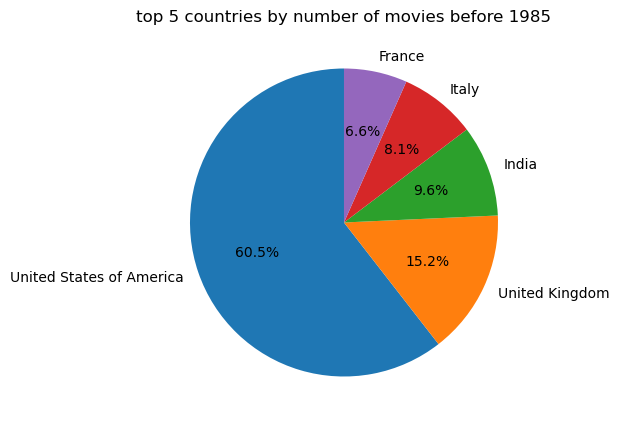

In [ ]:
fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c1.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies before 1985')
plt.show()
# plot_countries


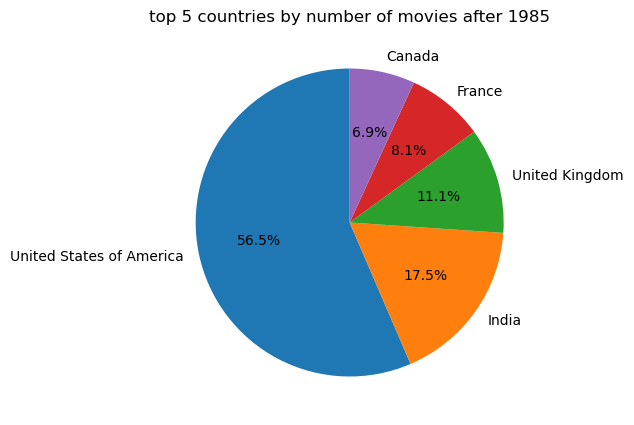

In [ ]:

fig, ax = plt.subplots(figsize=(11,5))
# fig.set_facecolor('white')
# fig.set_size_inches(11, 5)
# fig.suptitle('title')
plot_counts=c2.head(5)
plot_countries=plot_counts.index.to_series()
ax.pie(plot_counts, labels=plot_countries, startangle=90,autopct='%1.1f%%', radius=1)
ax.set_title('top 5 countries by number of movies after 1985')
plt.show()

In [ ]:
df_all['name'].to_csv('./handled_data/movie_names.csv', index=False)

# Train NN for predicting revenue

In [1819]:
df_all.columns

Index(['freebase_id', 'name', 'runtime', 'languages', 'countries',
       'release_year', 'directors', 'writers', 'WR', 'genre', 'release_day',
       'release_month', 'profit_modified', 'total_gross_modified',
       'budget_modified', 'pageviews'],
      dtype='object')

In [ ]:
movies_with_revenue = df_all[df_all['profit_modified'].notna()]

In [1820]:
df_all.describe()

,runtime,release_year,WR,release_day,release_month,profit_modified,total_gross_modified,budget_modified,pageviews
count,68104.000000,75770.000000,44031.000000,40527.000000,43783.000000,3.828000e+03,3.828000e+03,3.828000e+03,7.330000e+04
mean,93.965487,1977.970337,6.224498,15.658129,6.707717,1.022127e+08,1.531362e+08,5.092346e+07,5.087095e+03
std,59.949382,29.228281,1.102334,8.708538,3.483055,2.118785e+08,2.474730e+08,5.505716e+07,5.753066e+04
min,0.000000,1010.000000,1.131770,1.000000,1.000000,-1.887276e+08,0.000000e+00,8.981700e+03,0.000000e+00
25%,80.000000,1956.000000,5.614247,8.000000,4.000000,-4.110680e+05,2.186877e+07,1.411410e+07,4.350988e+01
50%,93.000000,1986.000000,6.317251,16.000000,7.000000,3.038498e+07,6.580837e+07,3.255200e+07,2.368342e+02
75%,108.000000,2004.000000,6.998635,23.000000,10.000000,1.134723e+08,1.742421e+08,6.673500e+07,1.277118e+03
max,5700.000000,2020.000000,9.467126,31.000000,12.000000,3.274088e+09,3.578183e+09,4.862949e+08,5.154324e+06


In [ ]:
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Normalization, LeakyReLU
from tensorflow.python.keras.models import Sequential

# from tensorflow.keras.metrics import Recall, Precision
# from tensorflow_addons.metrics import F1Score

In [ ]:
# profit_modified ~ release_year, release_month Certificate, WR, Director, Star1, runtime, languages, countries, budget_modified, pageviews, genre1

In [ ]:
movies_with_revenue.drop([
    'name', 'IMDB_Rating', 'Overview', 'Meta_score', 'No_of_Votes', 'wikipedia_id', 'freebase_id', 'release_day',
    'total_gross_modified', 'genre1', 'genre1_category'
], axis=1, inplace=True)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/2572595685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_with_revenue.drop([


In [ ]:
movies_with_revenue['Star'] = movies_with_revenue[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()
movies_with_revenue.drop(['Star1', 'Star2', 'Star3', 'Star4'], axis=1, inplace=True)

/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/1371635011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_with_revenue['Star'] = movies_with_revenue[['Star1', 'Star2', 'Star3', 'Star4']].values.tolist()
/var/folders/m_/fhwnh1jn04qgx3nmt22_5h340000gn/T/ipykernel_34242/1371635011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_with_revenue.drop(['Star1', 'Star2', 'Star3', 'Star4'], axis=1, inplace=True)


In [ ]:
movies_with_revenue.head()

,release_year,Certificate,Director,WR,runtime,languages,countries,genre,release_month,profit_modified,budget_modified,pageviews,Star
0,1994,A,Frank Darabont,9.285691,142.0,[English],[United States of America],"[Crime Fiction, Buddy film, Prison film, Drama...",9,4.560750e+06,33367500.0,193589.611331,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will..."
1,1972,A,Francis Ford Coppola,9.180931,177.0,"[Latin, Italian, Sicilian, English]",[United States of America],"[Crime Fiction, Gangster Film, Crime Drama, Fa...",3,3.353214e+08,8976100.0,360950.310771,"[Marlon Brando, Al Pacino, James Caan, Diane K..."
2,2008,UA,Christopher Nolan,8.988679,153.0,"[Standard Mandarin, English]","[United States of America, United Kingdom]","[Crime Fiction, Thriller, Superhero movie, Cri...",7,1.046680e+09,237373500.0,50247.217885,"[Christian Bale, Heath Ledger, Aaron Eckhart, ..."
3,1974,A,Francis Ford Coppola,8.977178,202.0,NaN,NaN,"[Crime, Drama]",12,9.012835e+07,26448500.0,222.491765,"[Al Pacino, Robert De Niro, Robert Duvall, Dia..."
4,1957,U,Sidney Lumet,8.963129,96.0,[English],[United States of America],[Drama],4,-4.235720e+05,423572.0,222.069170,"[Henry Fonda, Lee J. Cobb, Martin Balsam, John..."


In [ ]:
temp = movies_with_revenue.copy()

In [ ]:
movies_with_revenue.head()

,release_year,WR,runtime,release_month,profit_modified,budget_modified,pageviews,genre_Action,genre_Action/Adventure,genre_Adventure,...,Certificate_PG,Certificate_PG-13,Certificate_Passed,Certificate_R,Certificate_TV-14,Certificate_TV-MA,Certificate_U,Certificate_U/A,Certificate_UA,Certificate_Unrated
0,1994,9.285691,142.0,9,4.560750e+06,33367500.0,193589.611331,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1972,9.180931,177.0,3,3.353214e+08,8976100.0,360950.310771,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2008,8.988679,153.0,7,1.046680e+09,237373500.0,50247.217885,1,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1974,8.977178,202.0,12,9.012835e+07,26448500.0,222.491765,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1957,8.963129,96.0,4,-4.235720e+05,423572.0,222.069170,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
movies_with_revenue.describe()

,release_year,WR,runtime,release_month,profit_modified,budget_modified,pageviews,genre_Action,genre_Action/Adventure,genre_Adventure,...,Certificate_PG,Certificate_PG-13,Certificate_Passed,Certificate_R,Certificate_TV-14,Certificate_TV-MA,Certificate_U,Certificate_U/A,Certificate_UA,Certificate_Unrated
count,3841.0,442.000000,3841.000000,3841.0,3.841000e+03,3.841000e+03,3.799000e+03,3841.000000,3841.000000,3841.000000,...,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000,3841.000000
mean,2003.595418,7.952713,110.444285,6.945847,1.020213e+08,5.089654e+07,2.367793e+04,0.295496,0.150221,0.210102,...,0.141890,0.329341,0.002603,0.398334,0.000260,0.001041,0.027857,0.000260,0.027597,0.001822
std,12.752035,0.285557,25.800444,3.431196,2.116340e+08,5.498706e+07,9.250797e+04,0.456325,0.357335,0.407434,...,0.348983,0.470035,0.050965,0.489619,0.016135,0.032258,0.164585,0.016135,0.163836,0.042657
min,1925.0,7.614407,4.000000,1.0,-1.887276e+08,8.981700e+03,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1999.0,7.732619,96.000000,4.0,-4.548600e+05,1.411410e+07,6.646728e+02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2006.0,7.902599,106.000000,7.0,3.032431e+07,3.288200e+07,8.428578e+03,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2013.0,8.090418,120.000000,10.0,1.134429e+08,6.673500e+07,2.744422e+04,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2020.0,9.285691,1003.000000,12.0,3.274088e+09,4.862949e+08,5.154324e+06,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
movies_with_revenue.shape

(3841, 120)

In [ ]:
movies_with_revenue.columns

Index(['release_year', 'WR', 'runtime', 'release_month', 'profit_modified',
       'budget_modified', 'pageviews', 'genre_Action',
       'genre_Action/Adventure', 'genre_Adventure',
       ...
       'Certificate_PG', 'Certificate_PG-13', 'Certificate_Passed',
       'Certificate_R', 'Certificate_TV-14', 'Certificate_TV-MA',
       'Certificate_U', 'Certificate_U/A', 'Certificate_UA',
       'Certificate_Unrated'],
      dtype='object', length=120)

In [ ]:
movies_with_revenue = movies_with_revenue.astype('float32')

In [ ]:
dataset = movies_with_revenue[['release_year', 'runtime', 'release_month', 'profit_modified', 'budget_modified']]

In [ ]:
dataset.describe()

,release_year,runtime,release_month,profit_modified,budget_modified
count,3841.000000,3841.000000,3841.000000,3.841000e+03,3.841000e+03
mean,2003.595459,110.444283,6.945848,1.020213e+08,5.089654e+07
std,12.752043,25.800436,3.431193,2.116341e+08,5.498699e+07
min,1925.000000,4.000000,1.000000,-1.887276e+08,8.981700e+03
25%,1999.000000,96.000000,4.000000,-4.548600e+05,1.411410e+07
50%,2006.000000,106.000000,7.000000,3.032431e+07,3.288200e+07
75%,2013.000000,120.000000,10.000000,1.134429e+08,6.673500e+07
max,2020.000000,1003.000000,12.000000,3.274088e+09,4.862949e+08


In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [ ]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
release_year,3073.0,2.003673e+03,1.281394e+01,1.925000e+03,1.999000e+03,2006.0,2013.0,2.020000e+03
runtime,3073.0,1.103498e+02,2.160428e+01,4.000000e+00,9.600000e+01,106.0,120.0,3.660000e+02
release_month,3073.0,6.974617e+00,3.426362e+00,1.000000e+00,4.000000e+00,7.0,10.0,1.200000e+01
profit_modified,3073.0,1.013745e+08,2.095153e+08,-1.417187e+08,-4.531677e+05,30031358.0,113085296.0,3.274088e+09
budget_modified,3073.0,4.979537e+07,5.357717e+07,8.981700e+03,1.348162e+07,32077500.0,65659000.0,4.775200e+08


In [ ]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('profit_modified')
test_labels = test_features.pop('profit_modified')

In [ ]:
train_features.shape

(3073, 4)

In [ ]:
model = Sequential()
model.add(Normalization(axis=-1))
# model.add(Dense(50, activation="relu"))
# model.add(Dense(25, activation="relu"))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

In [ ]:
model.build((0, 4))
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_23 (ModuleWra (0, 4)                    9         
_________________________________________________________________
dense_69 (Dense)             (0, 1)                    5         
Total params: 14
Trainable params: 5
Non-trainable params: 9
_________________________________________________________________


In [ ]:
history = model.fit(train_features, train_labels, batch_size=32, epochs=1000, validation_split=0.2)

/Users/nstanishev/opt/anaconda3/envs/epfl-ada/lib/python3.9/site-packages/tensorflow/python/keras/engine/data_adapter.py:1516: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/1000


2022-12-05 11:30:26.741533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - ETA: 0s - loss: 152342272.0000 - accuracy: 0.0000e+00

2022-12-05 11:30:29.138186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


77/77 [==============================] - 4s 29ms/step - loss: 152342272.0000 - accuracy: 0.0000e+00 - val_loss: 155271760.0000 - val_accuracy: 0.0000e+00
Epoch 2/1000
77/77 [==============================] - 2s 22ms/step - loss: 148561744.0000 - accuracy: 0.0000e+00 - val_loss: 151665904.0000 - val_accuracy: 0.0000e+00
Epoch 3/1000
77/77 [==============================] - 2s 20ms/step - loss: 144895424.0000 - accuracy: 0.0000e+00 - val_loss: 148170784.0000 - val_accuracy: 0.0000e+00
Epoch 4/1000
77/77 [==============================] - 2s 21ms/step - loss: 141362320.0000 - accuracy: 0.0000e+00 - val_loss: 144743296.0000 - val_accuracy: 0.0000e+00
Epoch 5/1000
77/77 [==============================] - 1s 19ms/step - loss: 137959712.0000 - accuracy: 0.0000e+00 - val_loss: 141488416.0000 - val_accuracy: 0.0000e+00
Epoch 6/1000
77/77 [==============================] - 1s 16ms/step - loss: 134701216.0000 - accuracy: 0.0000e+00 - val_loss: 138290320.0000 - val_accuracy: 0.0000e+00
Epoch 7/100

KeyboardInterrupt: 

# Project Milestone 3: data story

## Study data for separate genre

In [ ]:
(df_all['genre']=='['']').any()

False

In [ ]:
frequency_genre = df_all['genre'].value_counts(sort=True).to_frame()


In [ ]:
frequency_genre.head()

,genre
[Drama],6888
[],2293
[Comedy],2043
[Documentary],2001
[Comedy film],1387


In [ ]:
type(frequency_genre.index[1])

list

## Impact of director

In [ ]:
df_director.columns

Index(['name', 'release_year', 'Certificate', 'IMDB_Rating', 'Overview',
       'Meta_score', 'Director', 'Star1', 'Star2', 'Star3', 'Star4',
       'No_of_Votes', 'WR', 'wikipedia_id', 'freebase_id', 'runtime',
       'languages', 'countries', 'genre', 'release_day', 'release_month',
       'profit_modified', 'total_gross_modified', 'budget_modified',
       'pageviews'],
      dtype='object')

In [ ]:
df_director = df_all.dropna(how='all', subset=['Director']) # Remove NaN directors

In [ ]:
Top20_ProfitableMovies = df_director.sort_values('profit_modified', ascending=False).head(20)

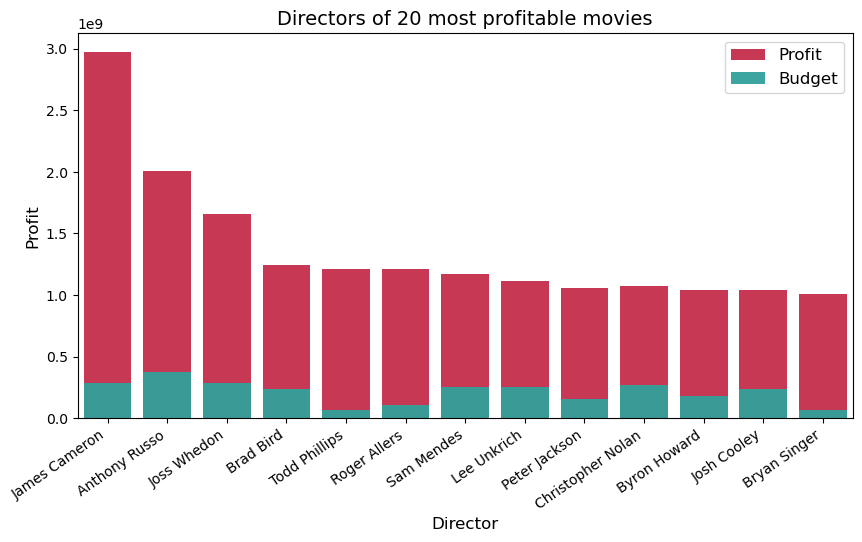

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['profit_modified'], 
            color='crimson', alpha=0.95, label='Profit', ci=None)
sns.barplot(x=Top20_ProfitableMovies['Director'],y=Top20_ProfitableMovies['budget_modified'], 
            color='lightseagreen', alpha=0.95, label='Budget', ci=None)
plt.xlabel('Director', fontsize=12)
plt.title("Directors of 20 most profitable movies", fontsize=14)
plt.ylabel('Profit', fontsize=12)
plt.xticks(rotation=35, horizontalalignment='right', fontsize=10)
plt.legend(fontsize=12)

In [ ]:
Top20_ProfitableMovies['Director']

623        James Cameron
59         Anthony Russo
652        James Cameron
60         Anthony Russo
357          Joss Whedon
891            Brad Bird
33         Todd Phillips
43          Roger Allers
751           Sam Mendes
151          Lee Unkrich
13         Peter Jackson
63     Christopher Nolan
583        Anthony Russo
618        Peter Jackson
2      Christopher Nolan
330         Byron Howard
596          Josh Cooley
10         Peter Jackson
5          Peter Jackson
342         Bryan Singer
Name: Director, dtype: object